In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import re
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm
import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import glob
import json
import random

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.losses import CTC
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [3]:
# 구글드라이브 파일 완전 삭제 관련 코드

# val_loss가 갱신될때마다 모델을 저장하게 했는데
# 저장된 모델이 쌓이면 구글드라이브 용량이 너무 차게되서
# val_loss가 가장 낮은 3개만 남겨놓고 삭제하기 위해 만들어진 함수들 입니다.

from google.colab import auth
auth.authenticate_user()

from googleapiclient.discovery import build
from googleapiclient.http import MediaFileUpload
from googleapiclient.errors import HttpError
import google.auth

creds, _ = google.auth.default()
drive_service = build('drive', 'v3', credentials=creds)

# 드라이브에 저장된 정보 가져오기
def get_file_id_by_name(filename):
    results = drive_service.files().list(
        q=f"name='{filename}'",
        spaces='drive',
        fields='files(id, name)',
        pageSize=10
    ).execute()
    items = results.get('files', [])
    if not items:
        print('파일을 찾을 수 없습니다.')
        return None
    for item in items:
        print(f"찾은 파일: {item['name']} (ID: {item['id']})")
    return items[0]['id']  # 첫 번째 일치 파일만 가져오기

# 드라이브에서 영구 삭제
def permanently_delete_file(file_id):
    try:
        drive_service.files().delete(fileId=file_id).execute()
        print("파일이 완전히 삭제되었습니다.")
    except HttpError as error:
        print(f"삭제 중 오류 발생: {error}")

# 파일 이름에서 val_loss값 추출
def extract_loss(filename):
    match = re.search(r"CTC_(\d+\.\d+)\.keras", filename)
    if match:
        return float(match.group(1))
    return float('inf')  # 매칭 안 되면 제일 큰 값으로 처리

In [4]:
path_info = pd.read_csv('/content/drive/MyDrive/Sesac/한상훈과아이들/pre_path_info_t312_m80_s156.csv')

In [5]:
len(path_info)

27519

In [6]:
x_data = np.load('/content/drive/MyDrive/Sesac/한상훈과아이들/x_data_t312_m80_s156.npy')
y_data = np.load('/content/drive/MyDrive/Sesac/한상훈과아이들/y_data_t312_m80_s156.npy')
x_data_length = np.load('/content/drive/MyDrive/Sesac/한상훈과아이들/x_data_length_t312_m80_s156.npy')
y_data_length = np.load('/content/drive/MyDrive/Sesac/한상훈과아이들/y_data_length_t312_m80_s156.npy')

In [7]:
x_data.shape, y_data.shape, x_data_length.shape, y_data_length.shape

((27519, 312, 80), (27519, 156), (27519,), (27519,))

In [8]:
max_wav_len = x_data.shape[1]
max_seq_len = max_wav_len/2

In [ ]:
@tf.keras.utils.register_keras_serializable(package="mask")
class SequenceMask(layers.Layer):
    def call(self, inputs):
        # 모든 feature가 패딩값(-80.0)인지 확인
        is_padding = tf.reduce_all(tf.equal(inputs, -80.0), axis=[-1, -2])
        is_valid = tf.logical_not(is_padding)
        lengths = tf.reduce_sum(tf.cast(is_valid, tf.int32), axis=-1)
        # stride=(2,2)로 인한 시간축 축소 반영
        lengths = tf.math.floordiv(lengths, 2)
        max_len = tf.math.floordiv(tf.shape(inputs)[1], 2)
        bool_mask = tf.sequence_mask(lengths, maxlen=max_len)
        int_mask = tf.sequence_mask(lengths, maxlen=max_len, dtype=tf.int32)
        int_mask = tf.expand_dims(int_mask, axis=-1)
        return bool_mask, int_mask

# *데이터 증강

In [ ]:
import numpy as np

# timstep과 mel-scale에 masking 넣는 함수
# mel: 멜 변환된 데이터 / (T, M) 또는 (B, T, M)
# time_mask_param:

def spec_augment_np(mel, true_lengths, time_mask_param=0.1, freq_mask_param=0.1,
                    num_time_masks=2, num_freq_masks=2, replace_val=-80.0):

    def _apply(x,L):
        T, M = x.shape
        L = int(min(max(L, 0), T))  # Length 확인
        out = x.copy()

        # Frequency masks
        f = int(np.floor(freq_mask_param * M))
        for _ in range(num_freq_masks):
            f0 = np.random.randint(0, M - f + 1)
            out[:, f0:f0+f] = replace_val

        # Time masks
        t = int(np.floor(time_mask_param * L))
        for _ in range(num_time_masks):
            t0 = np.random.randint(0, T - t + 1)
            out[t0:t0+t, :] = replace_val

        return out

    if mel.ndim == 3:  # (B, T, M)
        true_lengths = np.asarray(true_lengths)
        return np.stack([_apply(mel[i], int(true_lengths[i])) for i in range(mel.shape[0])], axis=0)
    else:              # (T, M)
        return _apply(mel, int(true_lengths))

# spec_augment_np 사용해서 Dataset 받기
def make_aug_dataset(x, x_len, y, num_aug, time_mask_param = 0.1, freq_mask_param = 0.15, num_time_masks = 2, num_freq_masks = 2, replace_val = -80.0):

    rng = np.random.default_rng()  # 재현성 원하면 고정

    N = x.shape[0]
    T, M = x.shape[1], x.shape[2]
    L = y.shape[1]

    idx = rng.choice(N, size=num_aug, replace=False)  # num_aug개 고유 샘플 선택

    # 증강 결과 담을 버퍼
    x_aug = np.empty((num_aug, T, M), dtype=x.dtype)
    y_aug = y[idx].copy()  # 라벨은 동일하게 복사

    for i, j in enumerate(idx):
        x_aug[i] = spec_augment_np(
            x[j],x_len[j],
            time_mask_param=time_mask_param,
            freq_mask_param=freq_mask_param,
            num_time_masks=num_time_masks,
            num_freq_masks=num_freq_masks,
            replace_val=replace_val
        )

    # 여기까지 하면 x_aug.shape = (4000, 312, 80), y_aug.shape = (4000, 156)

    # (옵션) 원본 + 증강 합치고 셔플해서 최종 학습셋 만들기
    use_ratio_merge = True
    if use_ratio_merge:
        x_train = np.concatenate([x, x_aug], axis=0)
        y_train = np.concatenate([y, y_aug], axis=0)

        # 섞기
        perm = rng.permutation(x_train.shape[0])
        x_train = x_train[perm]
        y_train = y_train[perm]

        print("Final train shape:", x_train.shape, y_train.shape)

        return x_train, y_train
    else:
        # 증강본만 따로 쓸 경우
        x_train, y_train = x_aug, y_aug
        print("Aug-only shape:", x_train.shape, y_train.shape)

        return x_train, y_train

In [ ]:
idx_list = random.sample(range(0, len(x_data)), len(x_data))
np.save('/content/drive/MyDrive/Sesac/한상훈과아이들/idx_list_1.npy',np.array(idx_list))

In [ ]:
# GRU * 5
def hardtanh(x, min_val=-20.0, max_val=20.0):
    return tf.clip_by_value(x, min_val, max_val)

def build_deepspeech2(input_shape=(312, 128, 1), num_classes=55, rnn_layer_num = 1):
    inputs = tf.keras.Input(shape=input_shape, name="input")

    # 1. Feature Extractor (MaskCNN)
    conv2d_1 = layers.Conv2D(32, kernel_size=(11, 41), strides=(2, 2), padding='same', use_bias=False)
    conv2d_1_out = conv2d_1(inputs)
    BatNor_1 = layers.BatchNormalization(momentum=0.1, epsilon=1e-5)
    BatNor_1_out = BatNor_1(conv2d_1_out)
    hardtanh_1 = layers.Activation(hardtanh)
    hardtanh_1_out = hardtanh_1(BatNor_1_out)

    conv2d_2 = layers.Conv2D(32, kernel_size=(11, 21), strides=(1, 2), padding='same', use_bias=False)
    conv2d_2_out = conv2d_2(hardtanh_1_out)
    BatNor_2 = layers.BatchNormalization(momentum=0.9, epsilon=1e-5)
    BatNor_2_out = BatNor_2(conv2d_2_out)
    hardtanh_2 = layers.Activation(hardtanh)
    hardtanh_2_out = hardtanh_2(BatNor_2_out)

    # 2. Reshape for RNN
    b, t, f, c = hardtanh_2_out.shape  # batch, time, freq, channel
    Reshape_1 = layers.Reshape((-1, f * c))
    x = Reshape_1(hardtanh_2_out)  # merge freq and channel

    x = layers.BatchNormalization(momentum=0.9, epsilon=1e-5)(x)
    x = layers.Bidirectional(layers.GRU(512,
                                        return_sequences=True,
                                        dropout=0.1,
                                        # kernel_regularizer=regularizers.l1_l2(l1=1e-06,l2=1e-04),
                                        # recurrent_regularizer=regularizers.l1_l2(l1=1e-06,l2=1e-04)
                                        ),
                              merge_mode='concat'
                              )(x)

    # 3. RNN Layers
    for i in range(rnn_layer_num):
        x = layers.BatchNormalization(momentum=0.9, epsilon=1e-5)(x)
        x = layers.Bidirectional(layers.GRU(1024,
                                            return_sequences=True,
                                            dropout=0.1,
                                            # kernel_regularizer=regularizers.l1_l2(l1=1e-06,l2=1e-04),
                                            # recurrent_regularizer=regularizers.l1_l2(l1=1e-06,l2=1e-04)
                                            ),
                                  merge_mode='concat'
                                  )(x)

    # 4. Fully Connected
    LayNor_1 = layers.LayerNormalization()
    LayNor_1_out = LayNor_1(x)
    dense_1 = layers.Dense(num_classes, use_bias=False)
    dense_1_out = dense_1(LayNor_1_out)

    return tf.keras.Model(inputs=inputs, outputs=dense_1_out)

# 모델 생성
rnn_5_model_1 = build_deepspeech2(input_shape=(312, 80, 1), rnn_layer_num = 4)
rnn_5_model_1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=CTC(), metrics=['accuracy'])

rnn_5_model_1.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 312, 80, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 156, 40, 32)    │        14,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 156, 40, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 156, 40, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 156, 20, 32)    │       236,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 156, 20, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 156, 20, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 156, 640)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 156, 640)       │         2,560 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 156, 1024)      │     3,545,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 156, 1024)      │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 156, 2048)      │    12,595,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 156, 2048)      │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 156, 2048)      │    18,886,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 156, 2048)      │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 156, 2048)      │    18,886,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 156, 2048)      │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 156, 2048)      │    18,886,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization             │ (None, 156, 2048)      │         4,096 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 156, 55)        │       112,640 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 73,199,456 (279.23 MB)

 Trainable params: 73,183,712 (279.17 MB)

 Non-trainable params: 15,744 (61.50 KB)

In [ ]:
# 저장 폴더 지정

save_folder = 'rnn_5_model_t312_m80_s156_1'
save_path = f"/content/drive/MyDrive/Sesac/한상훈과아이들/{save_folder}"

In [ ]:
# 최초 학습

train_model_history = {}
train_model_history_loss = []
train_model_history_val_loss = []
train_model_history_accuracy = []
train_model_history_val_accuracy = []

cnt_epoch = 1
min_loss = 900
min_val_loss = 900
previous_loss = 900
previous_val_loss = 900

diff_switch = True
rising_switch = True

diff_cnt = 0
rising_cnt = 0
stop_cnt = 10

# train_valid set 랜덤 지정
train_x_b_data = x_data[idx_list[:25000]]
train_y_b_data = y_data[idx_list[:25000]]
valid_x_data = x_data[idx_list[25000:27500]]
valid_y_data = y_data[idx_list[25000:27500]]
test_x_data = x_data[idx_list[27500:]]
test_y_data = y_data[idx_list[27500:]]


while diff_switch and rising_switch:

  print(f'epoch: {cnt_epoch}',end=' / ')

  temp_idx_list = random.sample(range(0, len(train_x_b_data)), len(train_x_b_data))
  train_x_data = train_x_b_data[temp_idx_list]
  train_y_data = train_y_b_data[temp_idx_list]

  train_model = rnn_5_model_1.fit(train_x_data,
                          train_y_data,
                          batch_size=64,
                          validation_data=(valid_x_data, valid_y_data),
                          # validation_split=0.1,
                          epochs=1,
                          # callbacks=[EarlyStopping(monitor='val_loss',patience=5),
                          #           ModelCheckpoint(filepath=save_path+'/KoSp_tf_CTC_{val_loss:3.4f}.keras', monitor='val_loss', save_best_only=True, verbose=1)]
                          )

  # 학습 history 저장
  cnt_epoch += 1

  train_model_history_loss.append(train_model.history['loss'][0])
  train_model_history_val_loss.append(train_model.history['val_loss'][0])
  train_model_history_accuracy.append(train_model.history['accuracy'][0])
  train_model_history_val_accuracy.append(train_model.history['val_accuracy'][0])

  train_model_history['loss'] = train_model_history_loss
  train_model_history['val_loss'] = train_model_history_val_loss
  train_model_history['accuracy'] = train_model_history_accuracy
  train_model_history['val_accuracy'] = train_model_history_val_accuracy

  t_loss = train_model.history['loss'][0]
  v_loss = train_model.history['val_loss'][0]

  t_v_ratio = ((v_loss-t_loss)/t_loss)

  if t_v_ratio > 0.3:
    diff_cnt += 1
  else:
    diff_cnt = 0

  if (t_loss > min_loss) and (v_loss > min_val_loss):
    rising_cnt += 1
  else:
    rising_cnt = 0

  if diff_cnt > stop_cnt:
    diff_switch = False
  else:
    diff_switch = True

  if rising_cnt > stop_cnt:
    rising_switch = False
  else:
    rising_switch = True

  print(f"diff_cnt: {diff_cnt} diff_switch: {diff_switch} / rising_cnt: {rising_cnt} rising_switch: {rising_switch}",end=' / ')

  previous_loss = t_loss
  previous_val_loss = v_loss

  if train_model.history['loss'][0] < float(min_loss):
    min_loss = train_model.history['loss'][0]
  # 학습된 val_loss값이 최소 val_loss보다 작으면 모델 저장
  if train_model.history['val_loss'][0] < float(min_val_loss):
    rnn_5_model_1.save(f"{save_path}/KoSp_tf_CTC_{train_model.history['val_loss'][0]:3.4f}.keras")
    print(f"***new*** min_val_loss:{train_model.history['val_loss'][0]:3.4f}")
    min_val_loss = train_model.history['val_loss'][0]
  # 학습된 val_loss값이 최소 val_loss보다 크면 patient +1
  else:
    print(f'min_val_loss: {min_val_loss}')
    continue

  # 저장된 모델이 3개가 넘어가면 가장 val_loss가 높은 모델 제거
  files = os.listdir(save_path)
  files.sort()

  files_with_loss = [(f, extract_loss(f)) for f in files]
  files_sorted = sorted(files_with_loss, key=lambda x: x[1])

  if len(files_sorted) > 1:
    top_k = 1
    files_to_remove = [f for f, _ in files_sorted[top_k:]]

    for filename in files_to_remove:
      file_id = get_file_id_by_name(filename)
      if file_id:
        permanently_delete_file(file_id)

391/391 ━━━━━━━━━━━━━━━━━━━━ 976s 2s/step - accuracy: 0.5121 - loss: 223.1864 - val_accuracy: 0.5555 - val_loss: 164.3325
diff_cnt: 0 diff_switch: True / rising_cnt: 0 rising_switch: True / ***new*** min_val_loss:164.3325
찾은 파일: KoSp_tf_CTC_335.8388.keras (ID: 1JPXoN0FkJmC7PD6F7R8BuZF9Jf933bQJ)
파일이 완전히 삭제되었습니다.
391/391 ━━━━━━━━━━━━━━━━━━━━ 962s 2s/step - accuracy: 0.5167 - loss: 155.8055 - val_accuracy: 0.4809 - val_loss: 150.3913
diff_cnt: 0 diff_switch: True / rising_cnt: 0 rising_switch: True / ***new*** min_val_loss:150.3913
찾은 파일: KoSp_tf_CTC_164.3325.keras (ID: 1nqIJ_tsadHbLgRrUhirVk0HiK0sSpiet)
파일이 완전히 삭제되었습니다.
391/391 ━━━━━━━━━━━━━━━━━━━━ 964s 2s/step - accuracy: 0.4931 - loss: 150.3394 - val_accuracy: 0.5108 - val_loss: 150.5116
diff_cnt: 0 diff_switch: True / rising_cnt: 0 rising_switch: True / min_val_loss: 150.3912811279297
391/391 ━━━━━━━━━━━━━━━━━━━━ 962s 2s/step - accuracy: 0.4990 - loss: 150.1109 - val_accuracy: 0.4824 - val_loss: 150.3394
diff_cnt: 0 diff_switch: True 

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Loss
ax[0].plot(train_model_history['loss'], label='Train Loss')
ax[0].plot(train_model_history['val_loss'], label='Val Loss')
ax[0].set_title('Loss')
ax[0].legend()
ax[0].grid(True)

# Accuracy
ax[1].plot(train_model_history['accuracy'], label='Train Accuracy')
ax[1].plot(train_model_history['val_accuracy'], label='Val Accuracy')
ax[1].set_title('Accuracy')
ax[1].legend()
ax[1].grid(True)

plt.show()
plt.savefig(f'/content/drive/MyDrive/Sesac/한상훈과아이들/{save_folder}/{save_folder}.png')

In [ ]:
# GRU Attention GRU
@tf.keras.utils.register_keras_serializable(package="hardtanh")
def hardtanh(x, min_val=-20.0, max_val=20.0):
    return tf.clip_by_value(x, min_val, max_val)

@tf.keras.utils.register_keras_serializable(package="mask")
class SequenceMask(layers.Layer):
    def call(self, inputs):
        # 모든 feature가 패딩값(-80.0)인지 확인
        is_padding = tf.reduce_all(tf.equal(inputs, -80.0), axis=[-1, -2])
        is_valid = tf.logical_not(is_padding)
        lengths = tf.reduce_sum(tf.cast(is_valid, tf.int32), axis=-1)
        # stride=(2,2)로 인한 시간축 축소 반영
        lengths = tf.math.floordiv(lengths, 2)
        max_len = tf.math.floordiv(tf.shape(inputs)[1], 2)
        bool_mask = tf.sequence_mask(lengths, maxlen=max_len)
        int_mask = tf.sequence_mask(lengths, maxlen=max_len, dtype=tf.int32)
        int_mask = tf.expand_dims(int_mask, axis=-1)
        return bool_mask, int_mask

def build_deepspeech2(input_shape=(312, 128, 1), num_classes=55):
    inputs = tf.keras.Input(shape=input_shape, name="input")

    x_data_bool_mask, x_data_int_mark = SequenceMask()(inputs)

    # 1. Feature Extractor (MaskCNN)
    conv2d_1 = layers.Conv2D(32, kernel_size=(11, 41), strides=(2, 2), padding='same', use_bias=False)
    conv2d_1_out = conv2d_1(inputs)
    BatNor_1 = layers.BatchNormalization(momentum=0.9, epsilon=1e-5)
    BatNor_1_out = BatNor_1(conv2d_1_out)
    hardtanh_1 = layers.Activation(hardtanh)
    hardtanh_1_out = hardtanh_1(BatNor_1_out)

    conv2d_2 = layers.Conv2D(32, kernel_size=(11, 21), strides=(1, 2), padding='same', use_bias=False)
    conv2d_2_out = conv2d_2(hardtanh_1_out)
    BatNor_2 = layers.BatchNormalization(momentum=0.9, epsilon=1e-5)
    BatNor_2_out = BatNor_2(conv2d_2_out)
    hardtanh_2 = layers.Activation(hardtanh)
    hardtanh_2_out = hardtanh_2(BatNor_2_out)

    # 2. Reshape for RNN
    b, t, f, c = hardtanh_2_out.shape  # batch, time, freq, channel
    Reshape_1 = layers.Reshape((-1, f * c))
    Reshape_1_out = Reshape_1(hardtanh_2_out)  # merge freq and channel

    # 3. RNN Layers
    BatNor_3 = layers.BatchNormalization(momentum=0.9, epsilon=1e-5)
    BatNor_3_out = BatNor_3(Reshape_1_out)
    GRU_1 = layers.Bidirectional(layers.GRU(512,
                                        return_sequences=True,
                                        dropout=0.1,
                                        # kernel_regularizer=regularizers.l1_l2(l1=1e-06,l2=1e-04),
                                        # recurrent_regularizer=regularizers.l1_l2(l1=1e-06,l2=1e-04)
                                        ),
                              merge_mode='concat'
                              )
    GRU_1_out = GRU_1(BatNor_3_out, mask=x_data_bool_mask)

    # 4. Attention
    Att_1 = layers.Attention()
    Att_1_out = Att_1([GRU_1_out,GRU_1_out])

    BatNor_4 = layers.BatchNormalization(momentum=0.9, epsilon=1e-5)
    BatNor_4_out = BatNor_4(Att_1_out)
    GRU_2 = layers.Bidirectional(layers.GRU(512,
                                        return_sequences=True,
                                        dropout=0.1,
                                        # kernel_regularizer=regularizers.l1_l2(l1=1e-06,l2=1e-04),
                                        # recurrent_regularizer=regularizers.l1_l2(l1=1e-06,l2=1e-04)
                                        ),
                              merge_mode='concat'
                              )
    GRU_2_out = GRU_2(BatNor_4_out)

    # 4. Fully Connected
    LayNor_1 = layers.LayerNormalization()
    LayNor_1_out = LayNor_1(GRU_2_out)
    dense_1 = layers.Dense(num_classes, use_bias=False)
    dense_1_out = dense_1(LayNor_1_out)

    return tf.keras.Model(inputs=inputs, outputs=dense_1_out)

# 모델 생성
rnn_Att_rnn_model = build_deepspeech2(input_shape=(312, 80, 1))
rnn_Att_rnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=CTC(), metrics=['accuracy'])

rnn_Att_rnn_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 312, 80,   │          0 │ -                 │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 156, 40,   │     14,432 │ input[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 156, 40,   │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 156, 40,   │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 156, 20,   │    236,544 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 156, 20,   │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 156, 20,   │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 156, 640)  │          0 │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 156, 640)  │      2,560 │ reshape[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequence_mask       │ [(None, 156),     │          0 │ input[0][0]       │
│ (SequenceMask)      │ (None, 156, 1)]   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 156, 1024) │  3,545,088 │ batch_normalizat… │
│ (Bidirectional)     │                   │            │ sequence_mask[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 156, 1024) │          0 │ bidirectional[0]… │
│ (Attention)         │                   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 156, 1024) │      4,096 │ attention[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 156, 1024) │  4,724,736 │ batch_normalizat… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 156, 1024) │      2,048 │ bidirectional_1[… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 156, 55)   │     56,320 │ layer_normalizat… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,586,080 (32.75 MB)

 Trainable params: 8,582,624 (32.74 MB)

 Non-trainable params: 3,456 (13.50 KB)

In [ ]:
# 저장 폴더 지정

save_folder = 'rnn_Att_rnn_model_t312_m80_s156_3'
save_path = f"/content/drive/MyDrive/Sesac/한상훈과아이들/{save_folder}"

In [ ]:
# 최초 학습

train_model_history = {}
train_model_history_loss = []
train_model_history_val_loss = []
train_model_history_accuracy = []
train_model_history_val_accuracy = []

cnt_epoch = 1
min_loss = 900
min_val_loss = 900
previous_loss = 900
previous_val_loss = 900

diff_switch = True
rising_switch = True

diff_cnt = 0
rising_cnt = 0
stop_cnt = 10

# train_valid set 랜덤 지정
train_x_b_data = x_data[idx_list[:25000]]
train_y_b_data = y_data[idx_list[:25000]]
valid_x_data = x_data[idx_list[25000:27500]]
valid_y_data = y_data[idx_list[25000:27500]]
test_x_data = x_data[idx_list[27500:]]
test_y_data = y_data[idx_list[27500:]]

np.save('/content/drive/MyDrive/Sesac/한상훈과아이들/idx_list.npy',np.array(idx_list))


while diff_switch and rising_switch:

  print(f'epoch: {cnt_epoch}',end=' / ')

  temp_idx_list = random.sample(range(0, len(train_x_b_data)), len(train_x_b_data))
  train_x_data = train_x_b_data[temp_idx_list]
  train_y_data = train_y_b_data[temp_idx_list]

  train_model = rnn_Att_rnn_model.fit(train_x_data,
                          train_y_data,
                          batch_size=64,
                          validation_data=(valid_x_data, valid_y_data),
                          # validation_split=0.1,
                          epochs=1,
                          # callbacks=[EarlyStopping(monitor='val_loss',patience=5),
                          #           ModelCheckpoint(filepath=save_path+'/KoSp_tf_CTC_{val_loss:3.4f}.keras', monitor='val_loss', save_best_only=True, verbose=1)]
                          )

  # 학습 history 저장
  cnt_epoch += 1

  train_model_history_loss.append(train_model.history['loss'][0])
  train_model_history_val_loss.append(train_model.history['val_loss'][0])
  train_model_history_accuracy.append(train_model.history['accuracy'][0])
  train_model_history_val_accuracy.append(train_model.history['val_accuracy'][0])

  train_model_history['loss'] = train_model_history_loss
  train_model_history['val_loss'] = train_model_history_val_loss
  train_model_history['accuracy'] = train_model_history_accuracy
  train_model_history['val_accuracy'] = train_model_history_val_accuracyatt

  t_loss = train_model.history['loss'][0]
  v_loss = train_model.history['val_loss'][0]

  t_v_ratio = ((v_loss-t_loss)/t_loss)

  if t_v_ratio > 0.3:
    diff_cnt += 1
  else:
    diff_cnt = 0

  if (t_loss > min_loss) and (v_loss > min_val_loss):
    rising_cnt += 1
  else:
    rising_cnt = 0

  if diff_cnt > stop_cnt:
    diff_switch = False
  else:
    diff_switch = True

  if rising_cnt > stop_cnt:
    rising_switch = False
  else:
    rising_switch = True

  print(f"diff_cnt: {diff_cnt} diff_switch: {diff_switch} / rising_cnt: {rising_cnt} rising_switch: {rising_switch}",end=' / ')

  previous_loss = t_loss
  previous_val_loss = v_loss

  if train_model.history['loss'][0] < float(min_loss):
    min_loss = train_model.history['loss'][0]
  # 학습된 val_loss값이 최소 val_loss보다 작으면 모델 저장
  if train_model.history['val_loss'][0] < float(min_val_loss):
    rnn_Att_rnn_model.save(f"{save_path}/KoSp_tf_CTC_{train_model.history['val_loss'][0]:3.4f}.keras")
    print(f"***new*** min_val_loss:{train_model.history['val_loss'][0]:3.4f}")
    min_val_loss = train_model.history['val_loss'][0]
  # 학습된 val_loss값이 최소 val_loss보다 크면 patient +1
  else:
    print(f'min_val_loss: {min_val_loss}')
    continue

  # 저장된 모델이 3개가 넘어가면 가장 val_loss가 높은 모델 제거
  files = os.listdir(save_path)
  files.sort()

  files_with_loss = [(f, extract_loss(f)) for f in files]
  files_sorted = sorted(files_with_loss, key=lambda x: x[1])

  if len(files_sorted) > 1:
    top_k = 1
    files_to_remove = [f for f, _ in files_sorted[top_k:]]

    for filename in files_to_remove:
      file_id = get_file_id_by_name(filename)
      if file_id:
        permanently_delete_file(file_id)

391/391 ━━━━━━━━━━━━━━━━━━━━ 436s 1s/step - accuracy: 0.5325 - loss: 198.6616 - val_accuracy: 0.5608 - val_loss: 161.3039
diff_cnt: 0 diff_switch: True / rising_cnt: 0 rising_switch: True / ***new*** min_val_loss:161.3039
파일을 찾을 수 없습니다.
찾은 파일: rnn_Att_rnn_model_t312_m80_s156_3.png (ID: 1cxdIiUgGuGdX9nvaCuN69M2Fh4VQmC4r)
파일이 완전히 삭제되었습니다.
391/391 ━━━━━━━━━━━━━━━━━━━━ 419s 1s/step - accuracy: 0.5563 - loss: 158.7152 - val_accuracy: 0.5256 - val_loss: 152.2913
diff_cnt: 0 diff_switch: True / rising_cnt: 0 rising_switch: True / ***new*** min_val_loss:152.2913
파일을 찾을 수 없습니다.
찾은 파일: KoSp_tf_CTC_161.3039.keras (ID: 1KO28usPHkAlu7L3D3BzAUlux000PYYoO)
파일이 완전히 삭제되었습니다.
391/391 ━━━━━━━━━━━━━━━━━━━━ 419s 1s/step - accuracy: 0.5330 - loss: 150.6389 - val_accuracy: 0.5259 - val_loss: 148.7849
diff_cnt: 0 diff_switch: True / rising_cnt: 0 rising_switch: True / ***new*** min_val_loss:148.7849
파일을 찾을 수 없습니다.
찾은 파일: KoSp_tf_CTC_152.2913.keras (ID: 1FVV_xdhUnLUXw9Ghozr7RtIortX62VY0)
파일이 완전히 삭제되었습니다.
391/3

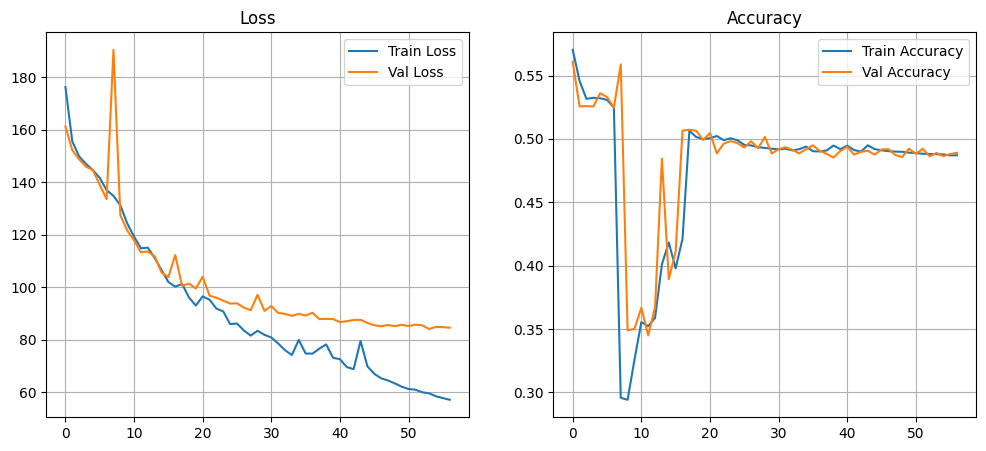

<Figure size 640x480 with 0 Axes>

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Loss
ax[0].plot(train_model_history['loss'], label='Train Loss')
ax[0].plot(train_model_history['val_loss'], label='Val Loss')
ax[0].set_title('Loss')
ax[0].legend()
ax[0].grid(True)

# Accuracy
ax[1].plot(train_model_history['accuracy'], label='Train Accuracy')
ax[1].plot(train_model_history['val_accuracy'], label='Val Accuracy')
ax[1].set_title('Accuracy')
ax[1].legend()
ax[1].grid(True)

plt.show()
plt.savefig(f'/content/drive/MyDrive/Sesac/한상훈과아이들/{save_folder}/{save_folder}.png')

In [ ]:
# GRU Attention * 2 GRU
@tf.keras.utils.register_keras_serializable(package="hardtanh")
def hardtanh(x, min_val=-20.0, max_val=20.0):
    return tf.clip_by_value(x, min_val, max_val)

@tf.keras.utils.register_keras_serializable(package="mask")
class SequenceMask(layers.Layer):
    def call(self, inputs):
        # 모든 feature가 패딩값(-80.0)인지 확인
        is_padding = tf.reduce_all(tf.equal(inputs, -80.0), axis=[-1, -2])
        is_valid = tf.logical_not(is_padding)
        lengths = tf.reduce_sum(tf.cast(is_valid, tf.int32), axis=-1)
        # stride=(2,2)로 인한 시간축 축소 반영
        lengths = tf.math.floordiv(lengths, 2)
        max_len = tf.math.floordiv(tf.shape(inputs)[1], 2)
        bool_mask = tf.sequence_mask(lengths, maxlen=max_len)
        int_mask = tf.sequence_mask(lengths, maxlen=max_len, dtype=tf.int32)
        int_mask = tf.expand_dims(int_mask, axis=-1)
        return bool_mask, int_mask

def build_deepspeech2(input_shape=(312, 128, 1), num_classes=55):
    inputs = tf.keras.Input(shape=input_shape, name="input")

    x_data_bool_mask, x_data_int_mark = SequenceMask()(inputs)

    # 1. Feature Extractor (MaskCNN)
    conv2d_1 = layers.Conv2D(32, kernel_size=(11, 41), strides=(2, 2), padding='same', use_bias=False)
    conv2d_1_out = conv2d_1(inputs)
    BatNor_1 = layers.BatchNormalization(momentum=0.9, epsilon=1e-5)
    BatNor_1_out = BatNor_1(conv2d_1_out)
    hardtanh_1 = layers.Activation(hardtanh)
    hardtanh_1_out = hardtanh_1(BatNor_1_out)

    conv2d_2 = layers.Conv2D(32, kernel_size=(11, 21), strides=(1, 2), padding='same', use_bias=False)
    conv2d_2_out = conv2d_2(hardtanh_1_out)
    BatNor_2 = layers.BatchNormalization(momentum=0.9, epsilon=1e-5)
    BatNor_2_out = BatNor_2(conv2d_2_out)
    hardtanh_2 = layers.Activation(hardtanh)
    hardtanh_2_out = hardtanh_2(BatNor_2_out)

    # 2. Reshape for RNN
    b, t, f, c = hardtanh_2_out.shape  # batch, time, freq, channel
    Reshape_1 = layers.Reshape((-1, f * c))
    Reshape_1_out = Reshape_1(hardtanh_2_out)  # merge freq and channel

    # 3. RNN Layers
    BatNor_3 = layers.BatchNormalization(momentum=0.9, epsilon=1e-5)
    BatNor_3_out = BatNor_3(Reshape_1_out)
    GRU_1 = layers.Bidirectional(layers.GRU(512,
                                        return_sequences=True,
                                        dropout=0.1,
                                        # kernel_regularizer=regularizers.l1_l2(l1=1e-06,l2=1e-04),
                                        # recurrent_regularizer=regularizers.l1_l2(l1=1e-06,l2=1e-04)
                                        ),
                              merge_mode='concat'
                              )
    GRU_1_out = GRU_1(BatNor_3_out, mask=x_data_bool_mask)

    # 4. Attention
    Att_1 = layers.Attention()
    Att_1_out = Att_1([GRU_1_out,GRU_1_out])

    BatNor_4 = layers.BatchNormalization(momentum=0.9, epsilon=1e-5)
    BatNor_4_out = BatNor_4(Att_1_out)
    GRU_2 = layers.Bidirectional(layers.GRU(512,
                                        return_sequences=True,
                                        dropout=0.1,
                                        # kernel_regularizer=regularizers.l1_l2(l1=1e-06,l2=1e-04),
                                        # recurrent_regularizer=regularizers.l1_l2(l1=1e-06,l2=1e-04)
                                        ),
                              merge_mode='concat'
                              )
    GRU_2_out = GRU_2(BatNor_4_out)

    Att_2 = layers.Attention()
    Att_2_out = Att_2([GRU_2_out,GRU_2_out])

    BatNor_5 = layers.BatchNormalization(momentum=0.9, epsilon=1e-5)
    BatNor_5_out = BatNor_5(Att_2_out)
    GRU_3 = layers.Bidirectional(layers.GRU(512,
                                        return_sequences=True,
                                        dropout=0.1,
                                        # kernel_regularizer=regularizers.l1_l2(l1=1e-06,l2=1e-04),
                                        # recurrent_regularizer=regularizers.l1_l2(l1=1e-06,l2=1e-04)
                                        ),
                              merge_mode='concat'
                              )
    GRU_3_out = GRU_3(BatNor_5_out)

    # 4. Fully Connected
    LayNor_1 = layers.LayerNormalization()
    LayNor_1_out = LayNor_1(GRU_3_out)
    dense_1 = layers.Dense(num_classes, use_bias=False)
    dense_1_out = dense_1(LayNor_1_out)

    return tf.keras.Model(inputs=inputs, outputs=dense_1_out)

# 모델 생성
rnn_Att_2_rnn_model = build_deepspeech2(input_shape=(312, 80, 1))
rnn_Att_2_rnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=CTC(), metrics=['accuracy'])

rnn_Att_2_rnn_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 312, 80,   │          0 │ -                 │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 156, 40,   │     14,432 │ input[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 156, 40,   │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 156, 40,   │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 156, 20,   │    236,544 │ activation_2[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 156, 20,   │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 156, 20,   │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 156, 640)  │          0 │ activation_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 156, 640)  │      2,560 │ reshape_1[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequence_mask_1     │ [(None, 156),     │          0 │ input[0][0]       │
│ (SequenceMask)      │ (None, 156, 1)]   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 156, 1024) │  3,545,088 │ batch_normalizat… │
│ (Bidirectional)     │                   │            │ sequence_mask_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_1         │ (None, 156, 1024) │          0 │ bidirectional_2[… │
│ (Attention)         │                   │            │ bidirectional_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 156, 1024) │      4,096 │ attention_1[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_3     │ (None, 156, 1024) │  4,724,736 │ batch_normalizat… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_2         │ (None, 156, 1024) │          0 │ bidirectional_3[… │
│ (Attention)         │                   │            │ bidirectional_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 156, 1024) │      4,096 │ attention_2[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_4     │ (None, 156, 1024) │  4,724,736 │ batch_normalizat… │
│ (Bidirectional)     │                   │            │                 

 Total params: 13,314,912 (50.79 MB)

 Trainable params: 13,309,408 (50.77 MB)

 Non-trainable params: 5,504 (21.50 KB)

In [ ]:
# 저장 폴더 지정

save_folder = 'rnn_Att_2_rnn_model_t312_m80_s156_3'
save_path = f"/content/drive/MyDrive/Sesac/한상훈과아이들/{save_folder}"

In [ ]:
# 최초 학습

train_model_history = {}
train_model_history_loss = []
train_model_history_val_loss = []
train_model_history_accuracy = []
train_model_history_val_accuracy = []

cnt_epoch = 1
min_loss = 900
min_val_loss = 900
previous_loss = 900
previous_val_loss = 900

diff_switch = True
rising_switch = True

diff_cnt = 0
rising_cnt = 0
stop_cnt = 10

# train_valid set 랜덤 지정
train_x_b_data = x_data[idx_list[:25000]]
train_y_b_data = y_data[idx_list[:25000]]
valid_x_data = x_data[idx_list[25000:27500]]
valid_y_data = y_data[idx_list[25000:27500]]
test_x_data = x_data[idx_list[27500:]]
test_y_data = y_data[idx_list[27500:]]


while diff_switch and rising_switch:

  print(f'epoch: {cnt_epoch}',end=' / ')

  temp_idx_list = random.sample(range(0, len(train_x_b_data)), len(train_x_b_data))
  train_x_data = train_x_b_data[temp_idx_list]
  train_y_data = train_y_b_data[temp_idx_list]

  train_model = rnn_Att_2_rnn_model.fit(train_x_data,
                          train_y_data,
                          batch_size=64,
                          validation_data=(valid_x_data, valid_y_data),
                          # validation_split=0.1,
                          epochs=1,
                          # callbacks=[EarlyStopping(monitor='val_loss',patience=5),
                          #           ModelCheckpoint(filepath=save_path+'/KoSp_tf_CTC_{val_loss:3.4f}.keras', monitor='val_loss', save_best_only=True, verbose=1)]
                          )

  # 학습 history 저장
  cnt_epoch += 1

  train_model_history_loss.append(train_model.history['loss'][0])
  train_model_history_val_loss.append(train_model.history['val_loss'][0])
  train_model_history_accuracy.append(train_model.history['accuracy'][0])
  train_model_history_val_accuracy.append(train_model.history['val_accuracy'][0])

  train_model_history['loss'] = train_model_history_loss
  train_model_history['val_loss'] = train_model_history_val_loss
  train_model_history['accuracy'] = train_model_history_accuracy
  train_model_history['val_accuracy'] = train_model_history_val_accuracy

  t_loss = train_model.history['loss'][0]
  v_loss = train_model.history['val_loss'][0]

  t_v_ratio = ((v_loss-t_loss)/t_loss)

  if t_v_ratio > 0.3:
    diff_cnt += 1
  else:
    diff_cnt = 0

  if (t_loss > min_loss) and (v_loss > min_val_loss):
    rising_cnt += 1
  else:
    rising_cnt = 0

  if diff_cnt > stop_cnt:
    diff_switch = False
  else:
    diff_switch = True

  if rising_cnt > stop_cnt:
    rising_switch = False
  else:
    rising_switch = True

  print(f"diff_cnt: {diff_cnt} diff_switch: {diff_switch} / rising_cnt: {rising_cnt} rising_switch: {rising_switch}",end=' / ')

  previous_loss = t_loss
  previous_val_loss = v_loss

  if train_model.history['loss'][0] < float(min_loss):
    min_loss = train_model.history['loss'][0]
  # 학습된 val_loss값이 최소 val_loss보다 작으면 모델 저장
  if train_model.history['val_loss'][0] < float(min_val_loss):
    rnn_Att_2_rnn_model.save(f"{save_path}/KoSp_tf_CTC_{train_model.history['val_loss'][0]:3.4f}.keras")
    print(f"***new*** min_val_loss:{train_model.history['val_loss'][0]:3.4f}")
    min_val_loss = train_model.history['val_loss'][0]
  # 학습된 val_loss값이 최소 val_loss보다 크면 patient +1
  else:
    print(f'min_val_loss: {min_val_loss}')
    continue

  # 저장된 모델이 3개가 넘어가면 가장 val_loss가 높은 모델 제거
  files = os.listdir(save_path)
  files.sort()

  files_with_loss = [(f, extract_loss(f)) for f in files]
  files_sorted = sorted(files_with_loss, key=lambda x: x[1])

  if len(files_sorted) > 1:
    top_k = 1
    files_to_remove = [f for f, _ in files_sorted[top_k:]]

    for filename in files_to_remove:
      file_id = get_file_id_by_name(filename)
      if file_id:
        permanently_delete_file(file_id)

391/391 ━━━━━━━━━━━━━━━━━━━━ 482s 1s/step - accuracy: 0.4090 - loss: 212.7935 - val_accuracy: 0.5231 - val_loss: 222.8626
diff_cnt: 0 diff_switch: True / rising_cnt: 0 rising_switch: True / ***new*** min_val_loss:222.8626
파일을 찾을 수 없습니다.
391/391 ━━━━━━━━━━━━━━━━━━━━ 473s 1s/step - accuracy: 0.5610 - loss: 159.8460 - val_accuracy: 0.5349 - val_loss: 152.1536
diff_cnt: 0 diff_switch: True / rising_cnt: 0 rising_switch: True / ***new*** min_val_loss:152.1536
파일을 찾을 수 없습니다.
찾은 파일: KoSp_tf_CTC_222.8626.keras (ID: 1Qm4EuXJHgnbHrsrw0Ojw6v-SaWPDh27z)
파일이 완전히 삭제되었습니다.
391/391 ━━━━━━━━━━━━━━━━━━━━ 473s 1s/step - accuracy: 0.5345 - loss: 151.9045 - val_accuracy: 0.5348 - val_loss: 150.7280
diff_cnt: 0 diff_switch: True / rising_cnt: 0 rising_switch: True / ***new*** min_val_loss:150.7280
파일을 찾을 수 없습니다.
찾은 파일: KoSp_tf_CTC_152.1536.keras (ID: 1ZZ61RtE-cZnAD91HW1jEp0bmnipAvzVY)
파일이 완전히 삭제되었습니다.
391/391 ━━━━━━━━━━━━━━━━━━━━ 473s 1s/step - accuracy: 0.5304 - loss: 149.1840 - val_accuracy: 0.5265 - val_

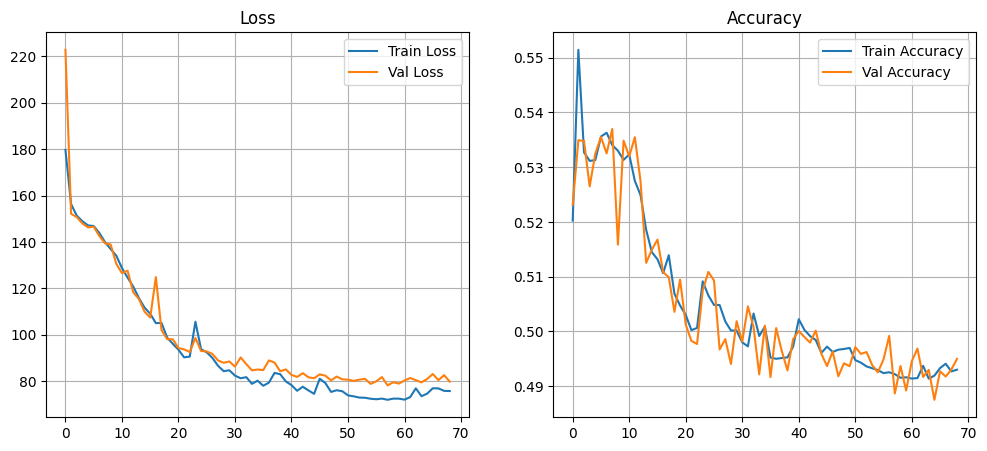

<Figure size 640x480 with 0 Axes>

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Loss
ax[0].plot(train_model_history['loss'], label='Train Loss')
ax[0].plot(train_model_history['val_loss'], label='Val Loss')
ax[0].set_title('Loss')
ax[0].legend()
ax[0].grid(True)

# Accuracy
ax[1].plot(train_model_history['accuracy'], label='Train Accuracy')
ax[1].plot(train_model_history['val_accuracy'], label='Val Accuracy')
ax[1].set_title('Accuracy')
ax[1].legend()
ax[1].grid(True)

plt.show()
plt.savefig(f'/content/drive/MyDrive/Sesac/한상훈과아이들/{save_folder}/{save_folder}.png')

In [ ]:
idx_list = random.sample(range(0, len(x_data)), len(x_data))
np.save('/content/drive/MyDrive/Sesac/한상훈과아이들/idx_list_2.npy',np.array(idx_list))

In [ ]:
# GRU * 5
def hardtanh(x, min_val=-20.0, max_val=20.0):
    return tf.clip_by_value(x, min_val, max_val)

def build_deepspeech2(input_shape=(312, 128, 1), num_classes=55, rnn_layer_num = 1):
    inputs = tf.keras.Input(shape=input_shape, name="input")

    # 1. Feature Extractor (MaskCNN)
    conv2d_1 = layers.Conv2D(32, kernel_size=(11, 41), strides=(2, 2), padding='same', use_bias=False)
    conv2d_1_out = conv2d_1(inputs)
    BatNor_1 = layers.BatchNormalization(momentum=0.1, epsilon=1e-5)
    BatNor_1_out = BatNor_1(conv2d_1_out)
    hardtanh_1 = layers.Activation(hardtanh)
    hardtanh_1_out = hardtanh_1(BatNor_1_out)

    conv2d_2 = layers.Conv2D(32, kernel_size=(11, 21), strides=(1, 2), padding='same', use_bias=False)
    conv2d_2_out = conv2d_2(hardtanh_1_out)
    BatNor_2 = layers.BatchNormalization(momentum=0.9, epsilon=1e-5)
    BatNor_2_out = BatNor_2(conv2d_2_out)
    hardtanh_2 = layers.Activation(hardtanh)
    hardtanh_2_out = hardtanh_2(BatNor_2_out)

    # 2. Reshape for RNN
    b, t, f, c = hardtanh_2_out.shape  # batch, time, freq, channel
    Reshape_1 = layers.Reshape((-1, f * c))
    x = Reshape_1(hardtanh_2_out)  # merge freq and channel

    x = layers.BatchNormalization(momentum=0.9, epsilon=1e-5)(x)
    x = layers.Bidirectional(layers.GRU(512,
                                        return_sequences=True,
                                        dropout=0.1,
                                        # kernel_regularizer=regularizers.l1_l2(l1=1e-06,l2=1e-04),
                                        # recurrent_regularizer=regularizers.l1_l2(l1=1e-06,l2=1e-04)
                                        ),
                              merge_mode='concat'
                              )(x)

    # 3. RNN Layers
    for i in range(rnn_layer_num):
        x = layers.BatchNormalization(momentum=0.9, epsilon=1e-5)(x)
        x = layers.Bidirectional(layers.GRU(1024,
                                            return_sequences=True,
                                            dropout=0.1,
                                            # kernel_regularizer=regularizers.l1_l2(l1=1e-06,l2=1e-04),
                                            # recurrent_regularizer=regularizers.l1_l2(l1=1e-06,l2=1e-04)
                                            ),
                                  merge_mode='concat'
                                  )(x)

    # 4. Fully Connected
    LayNor_1 = layers.LayerNormalization()
    LayNor_1_out = LayNor_1(x)
    dense_1 = layers.Dense(num_classes, use_bias=False)
    dense_1_out = dense_1(LayNor_1_out)

    return tf.keras.Model(inputs=inputs, outputs=dense_1_out)

# 모델 생성
rnn_5_model_2 = build_deepspeech2(input_shape=(312, 80, 1), rnn_layer_num = 4)
rnn_5_model_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=CTC(), metrics=['accuracy'])

rnn_5_model_2.summary()

In [ ]:
# 저장 폴더 지정

save_folder = 'rnn_5_model_t312_m80_s156_2'
save_path = f"/content/drive/MyDrive/Sesac/한상훈과아이들/{save_folder}"

In [ ]:
# 최초 학습

train_model_history = {}
train_model_history_loss = []
train_model_history_val_loss = []
train_model_history_accuracy = []
train_model_history_val_accuracy = []

cnt_epoch = 1
min_loss = 900
min_val_loss = 900
previous_loss = 900
previous_val_loss = 900

diff_switch = True
rising_switch = True

diff_cnt = 0
rising_cnt = 0
stop_cnt = 10

# train_valid set 랜덤 지정
aug_b_x_data = x_data[idx_list[:20000]]
aug_b_y_data = y_data[idx_list[:20000]]
valid_x_data = x_data[idx_list[20000:26000]]
valid_y_data = y_data[idx_list[20000:26000]]
test_x_data = x_data[idx_list[26000:]]
test_y_data = y_data[idx_list[26000:]]


while diff_switch and rising_switch:

  print(f'epoch: {cnt_epoch}',end=' / ')

  # 증간된 데이터 추가
  train_x_data, train_y_data = make_aug_dataset(aug_b_x_data,x_data_length,aug_b_y_data,10000)

  train_model = rnn_5_model_2.fit(train_x_data,
                          train_y_data,
                          batch_size=64,
                          validation_data=(valid_x_data, valid_y_data),
                          # validation_split=0.1,
                          epochs=1,
                          # callbacks=[EarlyStopping(monitor='val_loss',patience=5),
                          #           ModelCheckpoint(filepath=save_path+'/KoSp_tf_CTC_{val_loss:3.4f}.keras', monitor='val_loss', save_best_only=True, verbose=1)]
                          )

  # 학습 history 저장
  cnt_epoch += 1

  train_model_history_loss.append(train_model.history['loss'][0])
  train_model_history_val_loss.append(train_model.history['val_loss'][0])
  train_model_history_accuracy.append(train_model.history['accuracy'][0])
  train_model_history_val_accuracy.append(train_model.history['val_accuracy'][0])

  train_model_history['loss'] = train_model_history_loss
  train_model_history['val_loss'] = train_model_history_val_loss
  train_model_history['accuracy'] = train_model_history_accuracy
  train_model_history['val_accuracy'] = train_model_history_val_accuracy

  t_loss = train_model.history['loss'][0]
  v_loss = train_model.history['val_loss'][0]

  t_v_ratio = ((v_loss-t_loss)/t_loss)

  if t_v_ratio > 0.3:
    diff_cnt += 1
  else:
    diff_cnt = 0

  if (t_loss > min_loss) and (v_loss > min_val_loss):
    rising_cnt += 1
  else:
    rising_cnt = 0

  if diff_cnt > stop_cnt:
    diff_switch = False
  else:
    diff_switch = True

  if rising_cnt > stop_cnt:
    rising_switch = False
  else:
    rising_switch = True

  print(f"diff_cnt: {diff_cnt} diff_switch: {diff_switch} / rising_cnt: {rising_cnt} rising_switch: {rising_switch}",end=' / ')

  previous_loss = t_loss
  previous_val_loss = v_loss

  if train_model.history['loss'][0] < float(min_loss):
    min_loss = train_model.history['loss'][0]
  # 학습된 val_loss값이 최소 val_loss보다 작으면 모델 저장
  if train_model.history['val_loss'][0] < float(min_val_loss):
    rnn_5_model_2.save(f"{save_path}/KoSp_tf_CTC_{train_model.history['val_loss'][0]:3.4f}.keras")
    print(f"***new*** min_val_loss:{train_model.history['val_loss'][0]:3.4f}")
    min_val_loss = train_model.history['val_loss'][0]
  # 학습된 val_loss값이 최소 val_loss보다 크면 patient +1
  else:
    print(f'min_val_loss: {min_val_loss}')
    continue

  # 저장된 모델이 3개가 넘어가면 가장 val_loss가 높은 모델 제거
  files = os.listdir(save_path)
  files.sort()

  files_with_loss = [(f, extract_loss(f)) for f in files]
  files_sorted = sorted(files_with_loss, key=lambda x: x[1])

  if len(files_sorted) > 1:
    top_k = 1
    files_to_remove = [f for f, _ in files_sorted[top_k:]]

    for filename in files_to_remove:
      file_id = get_file_id_by_name(filename)
      if file_id:
        permanently_delete_file(file_id)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Loss
ax[0].plot(train_model_history['loss'], label='Train Loss')
ax[0].plot(train_model_history['val_loss'], label='Val Loss')
ax[0].set_title('Loss')
ax[0].legend()
ax[0].grid(True)

# Accuracy
ax[1].plot(train_model_history['accuracy'], label='Train Accuracy')
ax[1].plot(train_model_history['val_accuracy'], label='Val Accuracy')
ax[1].set_title('Accuracy')
ax[1].legend()
ax[1].grid(True)

plt.show()
plt.savefig(f'/content/drive/MyDrive/Sesac/한상훈과아이들/{save_folder}/{save_folder}.png')

In [ ]:
# GRU Attention GRU
def hardtanh(x, min_val=-20.0, max_val=20.0):
    return tf.clip_by_value(x, min_val, max_val)

@tf.keras.utils.register_keras_serializable(package="custom")
class SequenceMask(layers.Layer):
    def call(self, inputs):
        is_padding = tf.reduce_all(tf.equal(inputs, -80.0), axis=[-1,-2])
        is_valid = tf.logical_not(is_padding)
        lengths = tf.math.floordiv(tf.reduce_sum(tf.cast(is_valid, tf.int32), axis=-1),2)
        T = tf.math.floordiv(tf.shape(inputs)[1],2)
        # lengths = tf.expand_dims(lengths, axis=-1)
        return tf.sequence_mask(lengths, maxlen=T)

def build_deepspeech2(input_shape=(312, 128, 1), num_classes=55, rnn_layer_num = 1):
    inputs = tf.keras.Input(shape=input_shape, name="input")

    # 1. Feature Extractor (MaskCNN)
    conv2d_1 = layers.Conv2D(32, kernel_size=(11, 41), strides=(2, 2), padding='same', use_bias=False)
    conv2d_1_out = conv2d_1(inputs)
    BatNor_1 = layers.BatchNormalization(momentum=0.1, epsilon=1e-5)
    BatNor_1_out = BatNor_1(conv2d_1_out)
    hardtanh_1 = layers.Activation(hardtanh)
    hardtanh_1_out = hardtanh_1(BatNor_1_out)

    conv2d_2 = layers.Conv2D(32, kernel_size=(11, 21), strides=(1, 2), padding='same', use_bias=False)
    conv2d_2_out = conv2d_2(hardtanh_1_out)
    BatNor_2 = layers.BatchNormalization(momentum=0.9, epsilon=1e-5)
    BatNor_2_out = BatNor_2(conv2d_2_out)
    hardtanh_2 = layers.Activation(hardtanh)
    hardtanh_2_out = hardtanh_2(BatNor_2_out)

    # 2. Reshape for RNN
    b, t, f, c = hardtanh_2_out.shape  # batch, time, freq, channel
    Reshape_1 = layers.Reshape((-1, f * c))
    x = Reshape_1(hardtanh_2_out)  # merge freq and channel

    x_data_mask = SequenceMask()(x)

    # 3. RNN Layers
    for i in range(rnn_layer_num):
        x = layers.BatchNormalization(momentum=0.9, epsilon=1e-5)(x)
        x = layers.Bidirectional(layers.GRU(512,
                                            return_sequences=True,
                                            dropout=0.1,
                                            # kernel_regularizer=regularizers.l1_l2(l1=1e-06,l2=1e-04),
                                            # recurrent_regularizer=regularizers.l1_l2(l1=1e-06,l2=1e-04)
                                            ),
                                  merge_mode='concat'
                                  )(x, mask=x_data_mask)

    # 4. Attention
        att = layers.Attention()
        x = att([x,x], mask=[x_data_mask,x_data_mask])

    x = layers.BatchNormalization(momentum=0.9, epsilon=1e-5)(x)
    x = layers.Bidirectional(layers.GRU(512,
                                        return_sequences=True,
                                        dropout=0.1,
                                        # kernel_regularizer=regularizers.l1_l2(l1=1e-06,l2=1e-04),
                                        # recurrent_regularizer=regularizers.l1_l2(l1=1e-06,l2=1e-04)
                                        ),
                              merge_mode='concat'
                              )(x)

    # 4. Fully Connected
    LayNor_1 = layers.LayerNormalization()
    LayNor_1_out = LayNor_1(x)
    dense_1 = layers.Dense(num_classes, use_bias=False)
    dense_1_out = dense_1(LayNor_1_out)

    return tf.keras.Model(inputs=inputs, outputs=dense_1_out)

# 모델 생성
rnn_Att_rnn_model_2 = build_deepspeech2(input_shape=(312, 80, 1), rnn_layer_num = 1)
rnn_Att_rnn_model_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=CTC(), metrics=['accuracy'])

rnn_Att_rnn_model_2.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 312, 80,   │          0 │ -                 │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 156, 40,   │     14,432 │ input[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 156, 40,   │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 156, 40,   │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 156, 20,   │    236,544 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 156, 20,   │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 156, 20,   │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 156, 640)  │          0 │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 156, 640)  │      2,560 │ reshape[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 156, 1024) │  3,545,088 │ batch_normalizat… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 156, 1024) │          0 │ bidirectional[0]… │
│ (Attention)         │                   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 156, 1024) │      4,096 │ attention[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 156, 1024) │  4,724,736 │ batch_normalizat… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 156, 1024) │      2,048 │ bidirectional_1[… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 156, 55)   │     56,320 │ layer_normalizat… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,586,080 (32.75 MB)

 Trainable params: 8,582,624 (32.74 MB)

 Non-trainable params: 3,456 (13.50 KB)

In [ ]:
# 저장 폴더 지정

save_folder = 'rnn_Att_rnn_model_t312_m80_s156_4'
save_path = f"/content/drive/MyDrive/Sesac/한상훈과아이들/{save_folder}"

In [ ]:
# 최초 학습

train_model_history = {}
train_model_history_loss = []
train_model_history_val_loss = []
train_model_history_accuracy = []
train_model_history_val_accuracy = []

cnt_epoch = 1
min_loss = 900
min_val_loss = 900
previous_loss = 900
previous_val_loss = 900

diff_switch = True
rising_switch = True

diff_cnt = 0
rising_cnt = 0
stop_cnt = 10

# train_valid set 랜덤 지정
aug_b_x_data = x_data[idx_list[:20000]]
aug_b_y_data = y_data[idx_list[:20000]]
valid_x_data = x_data[idx_list[20000:26000]]
valid_y_data = y_data[idx_list[20000:26000]]
test_x_data = x_data[idx_list[26000:]]
test_y_data = y_data[idx_list[26000:]]


while diff_switch and rising_switch:

  print(f'epoch: {cnt_epoch}',end=' / ')

  # 증간된 데이터 추가
  train_x_data, train_y_data = make_aug_dataset(aug_b_x_data,x_data_length,aug_b_y_data,10000)

  train_model = rnn_Att_rnn_model_2.fit(train_x_data,
                          train_y_data,
                          batch_size=64,
                          validation_data=(valid_x_data, valid_y_data),
                          # validation_split=0.1,
                          epochs=1,
                          # callbacks=[EarlyStopping(monitor='val_loss',patience=5),
                          #           ModelCheckpoint(filepath=save_path+'/KoSp_tf_CTC_{val_loss:3.4f}.keras', monitor='val_loss', save_best_only=True, verbose=1)]
                          )

  # 학습 history 저장
  cnt_epoch += 1

  train_model_history_loss.append(train_model.history['loss'][0])
  train_model_history_val_loss.append(train_model.history['val_loss'][0])
  train_model_history_accuracy.append(train_model.history['accuracy'][0])
  train_model_history_val_accuracy.append(train_model.history['val_accuracy'][0])

  train_model_history['loss'] = train_model_history_loss
  train_model_history['val_loss'] = train_model_history_val_loss
  train_model_history['accuracy'] = train_model_history_accuracy
  train_model_history['val_accuracy'] = train_model_history_val_accuracy

  t_loss = train_model.history['loss'][0]
  v_loss = train_model.history['val_loss'][0]

  t_v_ratio = ((v_loss-t_loss)/t_loss)

  if t_v_ratio > 0.3:
    diff_cnt += 1
  else:
    diff_cnt = 0

  if (t_loss > min_loss) and (v_loss > min_val_loss):
    rising_cnt += 1
  else:
    rising_cnt = 0

  if diff_cnt > stop_cnt:
    diff_switch = False
  else:
    diff_switch = True

  if rising_cnt > stop_cnt:
    rising_switch = False
  else:
    rising_switch = True

  print(f"diff_cnt: {diff_cnt} diff_switch: {diff_switch} / rising_cnt: {rising_cnt} rising_switch: {rising_switch}",end=' / ')

  previous_loss = t_loss
  previous_val_loss = v_loss

  if train_model.history['loss'][0] < float(min_loss):
    min_loss = train_model.history['loss'][0]
  # 학습된 val_loss값이 최소 val_loss보다 작으면 모델 저장
  if train_model.history['val_loss'][0] < float(min_val_loss):
    rnn_Att_rnn_model_2.save(f"{save_path}/KoSp_tf_CTC_{train_model.history['val_loss'][0]:3.4f}.keras")
    print(f"***new*** min_val_loss:{train_model.history['val_loss'][0]:3.4f}")
    min_val_loss = train_model.history['val_loss'][0]
  # 학습된 val_loss값이 최소 val_loss보다 크면 patient +1
  else:
    print(f'min_val_loss: {min_val_loss}')
    continue

  # 저장된 모델이 3개가 넘어가면 가장 val_loss가 높은 모델 제거
  files = os.listdir(save_path)
  files.sort()

  files_with_loss = [(f, extract_loss(f)) for f in files]
  files_sorted = sorted(files_with_loss, key=lambda x: x[1])

  if len(files_sorted) > 1:
    top_k = 1
    files_to_remove = [f for f, _ in files_sorted[top_k:]]

    for filename in files_to_remove:
      file_id = get_file_id_by_name(filename)
      if file_id:
        permanently_delete_file(file_id)

epoch: 1 / Final train shape: (30000, 312, 80) (30000, 156)
469/469 ━━━━━━━━━━━━━━━━━━━━ 547s 1s/step - accuracy: 0.4841 - loss: 195.8893 - val_accuracy: 0.5258 - val_loss: 155.1853
diff_cnt: 0 diff_switch: True / rising_cnt: 0 rising_switch: True / ***new*** min_val_loss:155.1853
epoch: 2 / Final train shape: (30000, 312, 80) (30000, 156)
469/469 ━━━━━━━━━━━━━━━━━━━━ 532s 1s/step - accuracy: 0.5104 - loss: 152.6799 - val_accuracy: 0.5042 - val_loss: 146.4739
diff_cnt: 0 diff_switch: True / rising_cnt: 0 rising_switch: True / ***new*** min_val_loss:146.4739
찾은 파일: KoSp_tf_CTC_155.1853.keras (ID: 1kvsSJiip1sl9z8PbN2u9Oapq0rq-WE3w)
파일이 완전히 삭제되었습니다.
epoch: 3 / Final train shape: (30000, 312, 80) (30000, 156)
469/469 ━━━━━━━━━━━━━━━━━━━━ 532s 1s/step - accuracy: 0.4954 - loss: 146.3976 - val_accuracy: 0.5100 - val_loss: 143.7245
diff_cnt: 0 diff_switch: True / rising_cnt: 0 rising_switch: True / ***new*** min_val_loss:143.7245
찾은 파일: KoSp_tf_CTC_146.4739.keras (ID: 1336cD1k_BC20Zj8FDu93O9a

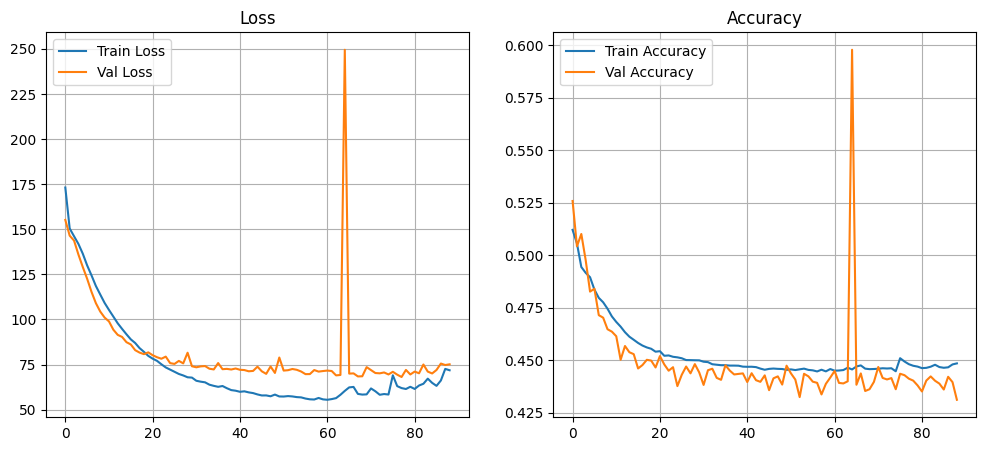

<Figure size 640x480 with 0 Axes>

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Loss
ax[0].plot(train_model_history['loss'], label='Train Loss')
ax[0].plot(train_model_history['val_loss'], label='Val Loss')
ax[0].set_title('Loss')
ax[0].legend()
ax[0].grid(True)

# Accuracy
ax[1].plot(train_model_history['accuracy'], label='Train Accuracy')
ax[1].plot(train_model_history['val_accuracy'], label='Val Accuracy')
ax[1].set_title('Accuracy')
ax[1].legend()
ax[1].grid(True)

plt.show()
plt.savefig(f'/content/drive/MyDrive/Sesac/한상훈과아이들/{save_folder}/{save_folder}.png')

In [ ]:
# GRU Attention * 2 GRU
def hardtanh(x, min_val=-20.0, max_val=20.0):
    return tf.clip_by_value(x, min_val, max_val)

@tf.keras.utils.register_keras_serializable(package="custom")
class SequenceMask(layers.Layer):
    def call(self, inputs):
        is_padding = tf.reduce_all(tf.equal(inputs, -80.0), axis=[-1,-2])
        is_valid = tf.logical_not(is_padding)
        lengths = tf.math.floordiv(tf.reduce_sum(tf.cast(is_valid, tf.int32), axis=-1),2)
        T = tf.math.floordiv(tf.shape(inputs)[1],2)
        # lengths = tf.expand_dims(lengths, axis=-1)
        return tf.sequence_mask(lengths, maxlen=T)

def build_deepspeech2(input_shape=(312, 128, 1), num_classes=55, rnn_layer_num = 1):
    inputs = tf.keras.Input(shape=input_shape, name="input")

    # 1. Feature Extractor (MaskCNN)
    conv2d_1 = layers.Conv2D(32, kernel_size=(11, 41), strides=(2, 2), padding='same', use_bias=False)
    conv2d_1_out = conv2d_1(inputs)
    BatNor_1 = layers.BatchNormalization(momentum=0.1, epsilon=1e-5)
    BatNor_1_out = BatNor_1(conv2d_1_out)
    hardtanh_1 = layers.Activation(hardtanh)
    hardtanh_1_out = hardtanh_1(BatNor_1_out)

    conv2d_2 = layers.Conv2D(32, kernel_size=(11, 21), strides=(1, 2), padding='same', use_bias=False)
    conv2d_2_out = conv2d_2(hardtanh_1_out)
    BatNor_2 = layers.BatchNormalization(momentum=0.9, epsilon=1e-5)
    BatNor_2_out = BatNor_2(conv2d_2_out)
    hardtanh_2 = layers.Activation(hardtanh)
    hardtanh_2_out = hardtanh_2(BatNor_2_out)

    # 2. Reshape for RNN
    b, t, f, c = hardtanh_2_out.shape  # batch, time, freq, channel
    Reshape_1 = layers.Reshape((-1, f * c))
    x = Reshape_1(hardtanh_2_out)  # merge freq and channel

    x_data_mask = SequenceMask()(x)

    # 3. RNN Layers
    for i in range(rnn_layer_num):
        x = layers.BatchNormalization(momentum=0.9, epsilon=1e-5)(x)
        x = layers.Bidirectional(layers.GRU(512,
                                            return_sequences=True,
                                            dropout=0.1,
                                            # kernel_regularizer=regularizers.l1_l2(l1=1e-06,l2=1e-04),
                                            # recurrent_regularizer=regularizers.l1_l2(l1=1e-06,l2=1e-04)
                                            ),
                                  merge_mode='concat'
                                  )(x, mask=x_data_mask)

    # 4. Attention
        att = layers.Attention()
        x = att([x,x], mask=[x_data_mask,x_data_mask])

    x = layers.BatchNormalization(momentum=0.9, epsilon=1e-5)(x)
    x = layers.Bidirectional(layers.GRU(512,
                                        return_sequences=True,
                                        dropout=0.1,
                                        # kernel_regularizer=regularizers.l1_l2(l1=1e-06,l2=1e-04),
                                        # recurrent_regularizer=regularizers.l1_l2(l1=1e-06,l2=1e-04)
                                        ),
                              merge_mode='concat'
                              )(x)

    # 4. Fully Connected
    LayNor_1 = layers.LayerNormalization()
    LayNor_1_out = LayNor_1(x)
    dense_1 = layers.Dense(num_classes, use_bias=False)
    dense_1_out = dense_1(LayNor_1_out)

    return tf.keras.Model(inputs=inputs, outputs=dense_1_out)

# 모델 생성
rnn_Att_2_rnn_model_2 = build_deepspeech2(input_shape=(312, 80, 1), rnn_layer_num = 2)
rnn_Att_2_rnn_model_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=CTC(), metrics=['accuracy'])

rnn_Att_2_rnn_model_2.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 312, 80,   │          0 │ -                 │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 156, 40,   │     14,432 │ input[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 156, 40,   │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 156, 40,   │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 156, 20,   │    236,544 │ activation_2[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 156, 20,   │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 156, 20,   │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 156, 640)  │          0 │ activation_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 156, 640)  │      2,560 │ reshape_1[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 156, 1024) │  3,545,088 │ batch_normalizat… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_1         │ (None, 156, 1024) │          0 │ bidirectional_2[… │
│ (Attention)         │                   │            │ bidirectional_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 156, 1024) │      4,096 │ attention_1[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_3     │ (None, 156, 1024) │  4,724,736 │ batch_normalizat… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_2         │ (None, 156, 1024) │          0 │ bidirectional_3[… │
│ (Attention)         │                   │            │ bidirectional_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 156, 1024) │      4,096 │ attention_2[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_4     │ (None, 156, 1024) │  4,724,736 │ batch_normalizat… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 156, 1024) │      2,048 │ bidirectional_4[… │
│ (LayerNormalizatio… │                   │            │                 

 Total params: 13,314,912 (50.79 MB)

 Trainable params: 13,309,408 (50.77 MB)

 Non-trainable params: 5,504 (21.50 KB)

In [ ]:
# 저장 폴더 지정

save_folder = 'rnn_Att_2_rnn_model_t312_m80_s156_4'
save_path = f"/content/drive/MyDrive/Sesac/한상훈과아이들/{save_folder}"

In [ ]:
# 최초 학습

train_model_history = {}
train_model_history_loss = []
train_model_history_val_loss = []
train_model_history_accuracy = []
train_model_history_val_accuracy = []

cnt_epoch = 1
min_loss = 900
min_val_loss = 900
previous_loss = 900
previous_val_loss = 900

diff_switch = True
rising_switch = True

diff_cnt = 0
rising_cnt = 0
stop_cnt = 10

# train_valid set 랜덤 지정
aug_b_x_data = x_data[idx_list[:20000]]
aug_b_y_data = y_data[idx_list[:20000]]
valid_x_data = x_data[idx_list[20000:26000]]
valid_y_data = y_data[idx_list[20000:26000]]
test_x_data = x_data[idx_list[26000:]]
test_y_data = y_data[idx_list[26000:]]


while diff_switch and rising_switch:

  print(f'epoch: {cnt_epoch}',end=' / ')

  # 증간된 데이터 추가
  train_x_data, train_y_data = make_aug_dataset(aug_b_x_data,x_data_length,aug_b_y_data,10000)

  train_model = rnn_Att_2_rnn_model_2.fit(train_x_data,
                          train_y_data,
                          batch_size=64,
                          validation_data=(valid_x_data, valid_y_data),
                          # validation_split=0.1,
                          epochs=1,
                          # callbacks=[EarlyStopping(monitor='val_loss',patience=5),
                          #           ModelCheckpoint(filepath=save_path+'/KoSp_tf_CTC_{val_loss:3.4f}.keras', monitor='val_loss', save_best_only=True, verbose=1)]
                          )

  # 학습 history 저장
  cnt_epoch += 1

  train_model_history_loss.append(train_model.history['loss'][0])
  train_model_history_val_loss.append(train_model.history['val_loss'][0])
  train_model_history_accuracy.append(train_model.history['accuracy'][0])
  train_model_history_val_accuracy.append(train_model.history['val_accuracy'][0])

  train_model_history['loss'] = train_model_history_loss
  train_model_history['val_loss'] = train_model_history_val_loss
  train_model_history['accuracy'] = train_model_history_accuracy
  train_model_history['val_accuracy'] = train_model_history_val_accuracy

  t_loss = train_model.history['loss'][0]
  v_loss = train_model.history['val_loss'][0]

  t_v_ratio = ((v_loss-t_loss)/t_loss)

  if t_v_ratio > 0.3:
    diff_cnt += 1
  else:
    diff_cnt = 0

  if (t_loss > min_loss) and (v_loss > min_val_loss):
    rising_cnt += 1
  else:
    rising_cnt = 0

  if diff_cnt > stop_cnt:
    diff_switch = False
  else:
    diff_switch = True

  if rising_cnt > stop_cnt:
    rising_switch = False
  else:
    rising_switch = True

  print(f"diff_cnt: {diff_cnt} diff_switch: {diff_switch} / rising_cnt: {rising_cnt} rising_switch: {rising_switch}",end=' / ')

  previous_loss = t_loss
  previous_val_loss = v_loss

  if train_model.history['loss'][0] < float(min_loss):
    min_loss = train_model.history['loss'][0]
  # 학습된 val_loss값이 최소 val_loss보다 작으면 모델 저장
  if train_model.history['val_loss'][0] < float(min_val_loss):
    rnn_Att_2_rnn_model_2.save(f"{save_path}/KoSp_tf_CTC_{train_model.history['val_loss'][0]:3.4f}.keras")
    print(f"***new*** min_val_loss:{train_model.history['val_loss'][0]:3.4f}")
    min_val_loss = train_model.history['val_loss'][0]
  # 학습된 val_loss값이 최소 val_loss보다 크면 patient +1
  else:
    print(f'min_val_loss: {min_val_loss}')
    continue

  # 저장된 모델이 3개가 넘어가면 가장 val_loss가 높은 모델 제거
  files = os.listdir(save_path)
  files.sort()

  files_with_loss = [(f, extract_loss(f)) for f in files]
  files_sorted = sorted(files_with_loss, key=lambda x: x[1])

  if len(files_sorted) > 1:
    top_k = 1
    files_to_remove = [f for f, _ in files_sorted[top_k:]]

    for filename in files_to_remove:
      file_id = get_file_id_by_name(filename)
      if file_id:
        permanently_delete_file(file_id)

epoch: 1 / Final train shape: (30000, 312, 80) (30000, 156)
469/469 ━━━━━━━━━━━━━━━━━━━━ 606s 1s/step - accuracy: 0.2865 - loss: 192.1154 - val_accuracy: 0.1913 - val_loss: 154.1028
diff_cnt: 0 diff_switch: True / rising_cnt: 0 rising_switch: True / ***new*** min_val_loss:154.1028
찾은 파일: KoSp_tf_CTC_196.9461.keras (ID: 1MRSMcnlqCHXOK7yAP5EIDDawAbjYhfoV)
파일이 완전히 삭제되었습니다.
epoch: 2 / Final train shape: (30000, 312, 80) (30000, 156)
469/469 ━━━━━━━━━━━━━━━━━━━━ 596s 1s/step - accuracy: 0.2232 - loss: 153.0618 - val_accuracy: 0.1888 - val_loss: 149.6835
diff_cnt: 0 diff_switch: True / rising_cnt: 0 rising_switch: True / ***new*** min_val_loss:149.6835
찾은 파일: KoSp_tf_CTC_154.1028.keras (ID: 19uDwx8rbU4vsMhyC2ydyYcgAS5ow4lWl)
파일이 완전히 삭제되었습니다.
epoch: 3 / Final train shape: (30000, 312, 80) (30000, 156)
469/469 ━━━━━━━━━━━━━━━━━━━━ 596s 1s/step - accuracy: 0.2963 - loss: 150.6537 - val_accuracy: 0.4819 - val_loss: 147.5942
diff_cnt: 0 diff_switch: True / rising_cnt: 0 rising_switch: True / ***n

In [ ]:
files = os.listdir(save_path)
files.sort()
files_with_loss = [(f, extract_loss(f)) for f in files]
files_sorted = sorted(files_with_loss, key=lambda x: x[1])
min_loss_file = [f for f, _ in files_sorted[0:1]]
min_val_loss = min_loss_file[0].split('CTC_')[1].split('.k')[0]

model_path = f"{save_path}/{min_loss_file[0]}"
def hardtanh(x, min_val=-20.0, max_val=20.0):
  return tf.clip_by_value(x, min_val, max_val)

print(model_path)

rnn_Att_2_rnn_model_2 = tf.keras.models.load_model(
  model_path,
  custom_objects={
    "hardtanh": hardtanh,
    'CTC': CTC()
    }
)
rnn_Att_2_rnn_model_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=CTC(), metrics=['accuracy'])

/content/drive/MyDrive/Sesac/한상훈과아이들/rnn_Att_2_rnn_model_t312_m80_s156_2/KoSp_tf_CTC_74.2140.keras


In [ ]:
# 최초 학습

train_model_history = {}
train_model_history_loss = []
train_model_history_val_loss = []
train_model_history_accuracy = []
train_model_history_val_accuracy = []

cnt_epoch = 1
min_loss = 900
min_val_loss = 900
previous_loss = 900
previous_val_loss = 900

diff_switch = True
rising_switch = True

diff_cnt = 0
rising_cnt = 0
stop_cnt = 10

# train_valid set 랜덤 지정
aug_b_x_data = x_data[idx_list[:20000]]
aug_b_y_data = y_data[idx_list[:20000]]
valid_x_data = x_data[idx_list[20000:26000]]
valid_y_data = y_data[idx_list[20000:26000]]
test_x_data = x_data[idx_list[26000:]]
test_y_data = y_data[idx_list[26000:]]


while diff_switch and rising_switch:

  print(f'epoch: {cnt_epoch}',end=' / ')

  # 증간된 데이터 추가
  train_x_data, train_y_data = make_aug_dataset(aug_b_x_data,x_data_length,aug_b_y_data,10000)

  train_model = rnn_Att_2_rnn_model_2.fit(train_x_data,
                          train_y_data,
                          batch_size=64,
                          validation_data=(valid_x_data, valid_y_data),
                          # validation_split=0.1,
                          epochs=1,
                          # callbacks=[EarlyStopping(monitor='val_loss',patience=5),
                          #           ModelCheckpoint(filepath=save_path+'/KoSp_tf_CTC_{val_loss:3.4f}.keras', monitor='val_loss', save_best_only=True, verbose=1)]
                          )

  # 학습 history 저장
  cnt_epoch += 1

  train_model_history_loss.append(train_model.history['loss'][0])
  train_model_history_val_loss.append(train_model.history['val_loss'][0])
  train_model_history_accuracy.append(train_model.history['accuracy'][0])
  train_model_history_val_accuracy.append(train_model.history['val_accuracy'][0])

  train_model_history['loss'] = train_model_history_loss
  train_model_history['val_loss'] = train_model_history_val_loss
  train_model_history['accuracy'] = train_model_history_accuracy
  train_model_history['val_accuracy'] = train_model_history_val_accuracy

  t_loss = train_model.history['loss'][0]
  v_loss = train_model.history['val_loss'][0]

  t_v_ratio = ((v_loss-t_loss)/t_loss)

  if t_v_ratio > 0.3:
    diff_cnt += 1
  else:
    diff_cnt = 0

  if (t_loss > min_loss) and (v_loss > min_val_loss):
    rising_cnt += 1
  else:
    rising_cnt = 0

  if diff_cnt > stop_cnt:
    diff_switch = False
  else:
    diff_switch = True

  if rising_cnt > stop_cnt:
    rising_switch = False
  else:
    rising_switch = True

  print(f"diff_cnt: {diff_cnt} diff_switch: {diff_switch} / rising_cnt: {rising_cnt} rising_switch: {rising_switch}",end=' / ')

  previous_loss = t_loss
  previous_val_loss = v_loss

  if train_model.history['loss'][0] < float(min_loss):
    min_loss = train_model.history['loss'][0]
  # 학습된 val_loss값이 최소 val_loss보다 작으면 모델 저장
  if train_model.history['val_loss'][0] < float(min_val_loss):
    rnn_Att_2_rnn_model_2.save(f"{save_path}/KoSp_tf_CTC_{train_model.history['val_loss'][0]:3.4f}.keras")
    print(f"***new*** min_val_loss:{train_model.history['val_loss'][0]:3.4f}")
    min_val_loss = train_model.history['val_loss'][0]
  # 학습된 val_loss값이 최소 val_loss보다 크면 patient +1
  else:
    print(f'min_val_loss: {min_val_loss}')
    continue

  # 저장된 모델이 3개가 넘어가면 가장 val_loss가 높은 모델 제거
  files = os.listdir(save_path)
  files.sort()

  files_with_loss = [(f, extract_loss(f)) for f in files]
  files_sorted = sorted(files_with_loss, key=lambda x: x[1])

  if len(files_sorted) > 1:
    top_k = 1
    files_to_remove = [f for f, _ in files_sorted[top_k:]]

    for filename in files_to_remove:
      file_id = get_file_id_by_name(filename)
      if file_id:
        permanently_delete_file(file_id)

epoch: 1 / Final train shape: (30000, 312, 80) (30000, 156)
469/469 ━━━━━━━━━━━━━━━━━━━━ 620s 1s/step - accuracy: 0.4374 - loss: 76.5826 - val_accuracy: 0.4306 - val_loss: 61.1913
diff_cnt: 0 diff_switch: True / rising_cnt: 0 rising_switch: True / ***new*** min_val_loss:61.1913
찾은 파일: KoSp_tf_CTC_74.2140.keras (ID: 1HIWzOnMuj-CMdXmYmlUmRZGPefmHqmIL)
파일이 완전히 삭제되었습니다.
epoch: 2 / Final train shape: (30000, 312, 80) (30000, 156)
469/469 ━━━━━━━━━━━━━━━━━━━━ 605s 1s/step - accuracy: 0.4357 - loss: 74.3035 - val_accuracy: 0.4357 - val_loss: 62.6239
diff_cnt: 0 diff_switch: True / rising_cnt: 0 rising_switch: True / min_val_loss: 61.19126510620117
epoch: 3 / Final train shape: (30000, 312, 80) (30000, 156)
469/469 ━━━━━━━━━━━━━━━━━━━━ 604s 1s/step - accuracy: 0.4356 - loss: 74.0205 - val_accuracy: 0.4326 - val_loss: 62.0960
diff_cnt: 0 diff_switch: True / rising_cnt: 0 rising_switch: True / min_val_loss: 61.19126510620117
epoch: 4 / Final train shape: (30000, 312, 80) (30000, 156)
469/469 ━━━

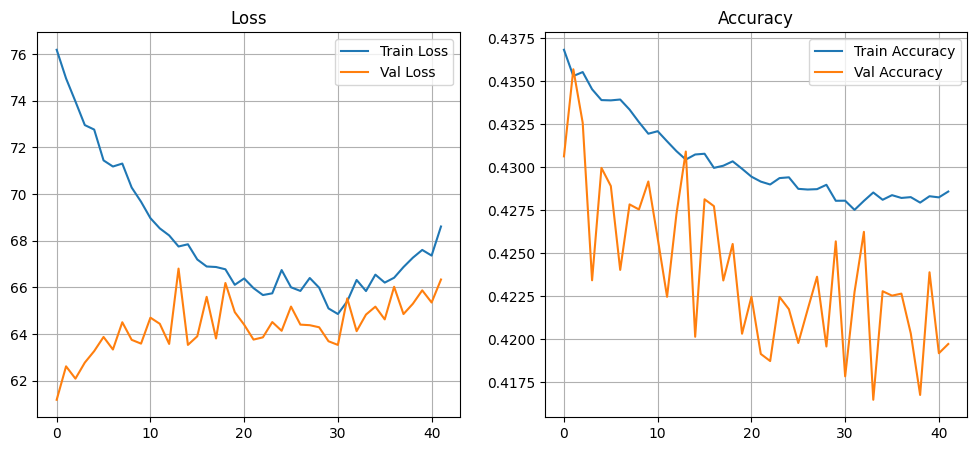

<Figure size 640x480 with 0 Axes>

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Loss
ax[0].plot(train_model_history['loss'], label='Train Loss')
ax[0].plot(train_model_history['val_loss'], label='Val Loss')
ax[0].set_title('Loss')
ax[0].legend()
ax[0].grid(True)

# Accuracy
ax[1].plot(train_model_history['accuracy'], label='Train Accuracy')
ax[1].plot(train_model_history['val_accuracy'], label='Val Accuracy')
ax[1].set_title('Accuracy')
ax[1].legend()
ax[1].grid(True)

plt.show()
plt.savefig(f'/content/drive/MyDrive/Sesac/한상훈과아이들/{save_folder}/{save_folder}.png')

In [ ]:
# 1. 자모 리스트 정의
CHOSUNG_LIST = ['ㄱ','ㄲ','ㄴ','ㄷ','ㄸ','ㄹ','ㅁ','ㅂ','ㅃ','ㅅ','ㅆ',
                'ㅇ','ㅈ','ㅉ','ㅊ','ㅋ','ㅌ','ㅍ','ㅎ']
JUNGSUNG_LIST = ['ㅏ','ㅐ','ㅑ','ㅒ','ㅓ','ㅔ','ㅕ','ㅖ','ㅗ','ㅘ','ㅙ',
                 'ㅚ','ㅛ','ㅜ','ㅝ','ㅞ','ㅟ','ㅠ','ㅡ','ㅢ','ㅣ']
JONGSUNG_LIST = ['','ㄱ','ㄲ','ㄳ','ㄴ','ㄵ','ㄶ','ㄷ','ㄹ','ㄺ','ㄻ',
                 'ㄼ','ㄽ','ㄾ','ㄿ','ㅀ','ㅁ','ㅂ','ㅄ','ㅅ','ㅆ',
                 'ㅇ','ㅈ','ㅊ','ㅋ','ㅌ','ㅍ','ㅎ']
RESERVED = ["<pad>", "<sos>", "<eos>", " "]  # <pad> == <blank>

# 자모 인덱스 테이블 만들기
ALL_JAMOS = sorted(set(CHOSUNG_LIST + JUNGSUNG_LIST + JONGSUNG_LIST))
ALL_JAMOS.remove('')  # 종성의 공백 제거

ALL_JAMOS = RESERVED + ALL_JAMOS

# 자모 사전 만들기
jamo_to_index = {j: i for i, j in enumerate(ALL_JAMOS)}
index_to_jamo = {i: j for j, i in jamo_to_index.items()}

vocab_size = len(jamo_to_index)

# 2. 자모 분해 함수
def decompose_hangul(text):
    result = ["<sos>"]
    for char in text:
        if '가' <= char <= '힣':
            code = ord(char) - ord('가')
            cho = CHOSUNG_LIST[code // (21*28)]
            jung = JUNGSUNG_LIST[(code % (21*28)) // 28]
            jong = JONGSUNG_LIST[code % 28]
            result.extend([cho, jung])
            if jong != '':
                result.append(jong)
        else:
            result.append(char)
    result.append("<eos>")
    return result

# 3. 자모 복원 함수
def compose_jamos(jamo_sequence):
    jamo_sequence = jamo_sequence[1:-1]
    result = ''
    i = 0
    while i < len(jamo_sequence):
        ch = jamo_sequence[i] if i < len(jamo_sequence) else ''
        ju = jamo_sequence[i + 1] if i + 1 < len(jamo_sequence) else ''
        jo = jamo_sequence[i + 2] if i + 2 < len(jamo_sequence) else ''

        # 조건: 초성 + 중성
        if ch in CHOSUNG_LIST and ju in JUNGSUNG_LIST:
            has_jong = False

            # 3번째 자모가 종성으로 판단될 때만 종성으로 사용
            if jo in JONGSUNG_LIST:
                # 다음 글자의 초성을 훔쳐보자
                next_ch = jamo_sequence[i + 3] if i + 3 < len(jamo_sequence) else ''
                if next_ch in CHOSUNG_LIST or next_ch == " ":
                    has_jong = True

            if has_jong:
                code = 0xAC00 + (
                    CHOSUNG_LIST.index(ch) * 21 * 28 +
                    JUNGSUNG_LIST.index(ju) * 28 +
                    JONGSUNG_LIST.index(jo)
                )
                result += chr(code)
                i += 3
            else:
                code = 0xAC00 + (
                    CHOSUNG_LIST.index(ch) * 21 * 28 +
                    JUNGSUNG_LIST.index(ju) * 28
                )
                result += chr(code)
                i += 2
        else:
            # 조합 불가능한 경우 그대로 출력
            result += ch
            i += 1

    return result

# 4. 전체 파이프라인
def text_to_ctc_indices(text):
    text = re.sub(r'[^가-힣 ]', '', text)

    jamo_seq = decompose_hangul(text)  # 자모 분해
    jamo_seq = jamo_seq[1:] if jamo_seq[0] == " " else jamo_seq
    jamo_seq = jamo_seq[:-1] if jamo_seq[-1] == " " else jamo_seq

    indices = [jamo_to_index[j] for j in jamo_seq if j in jamo_to_index]  # 인덱싱

    compose = compose_jamos(jamo_seq)  # 복원

    return text, jamo_seq, indices, compose

# 5. 예시 실행
text = "숙주도 있어서 넣고 이것저것 해서"
text, jamo_seq, indices, compose  = text_to_ctc_indices(text)

# 결과 출력
print("✅ 원문:", text)
print("✅ 원문 분해:", jamo_seq)
print("✅ 원문 시퀀스:",indices)
print("✅ 원문 복원:", compose)

In [ ]:
# audio 파일 -> 멜변환, audio time_step
def audio_preprocess(wav, sr=16000, n_mels=128):
  ori_y1, sr1 = librosa.load(wav, sr=sr)
  mel_spec1 = librosa.feature.melspectrogram(y=ori_y1, sr=sr1, n_mels=n_mels)
  mel_db1 = librosa.power_to_db(mel_spec1, ref=np.max)
  with open(wav, 'rb') as f:
    wav_data = f.read()
  bytes_per_sample = 2
  duration = len(wav_data) / (sr * bytes_per_sample)

  return mel_db1, round(duration, 3), mel_db1.shape[1]

In [ ]:
# json파일 -> 문장, 토큰화문장, 문장길이
def script_preprocess(json_file):
  with open(json_file, 'r') as f:
    json_data = json.load(f)
    script = json_data['발화정보']['stt']
    seq = decompose_hangul(json_data['발화정보']['stt'])
    seq_2_id = [jamo_to_index[j] for j in seq if j in jamo_to_index]

  return script, seq_2_id, len(seq_2_id)

In [ ]:
def wav_padding(wav, wav_max_len=312):
  pad_width = wav_max_len - wav.shape[1]  # 얼마나 채워야 하는지
  if pad_width > 0:
      # 오른쪽(열 끝)에 0을 채움: ((행 시작, 행 끝), (열 시작, 열 끝))
      padded = np.pad(wav, pad_width=((0, 0), (0, pad_width)), mode='constant', constant_values=-80)
  else:
      padded = wav  # 이미 가장 김
  return padded

In [ ]:
def scr_padding(scr, seq_max_len=78):
  pad_width = seq_max_len - len(scr)  # 얼마나 채워야 하는지
  if pad_width > 0:
      # 오른쪽(열 끝)에 0을 채움: ((행 시작, 행 끝), (열 시작, 열 끝))
      for _ in range(pad_width):
        scr.append(0)
  return scr

In [ ]:
def pred_preprocess(wav_path, sr=16000, n_mels=128):
  pred_wav = wav_path
  pred_,_,_ = audio_preprocess(pred_wav,sr,n_mels)
  padd_pred = wav_padding(pred_)
  x_padded_pred_data = np.stack([padd_pred])
  pred_audio_transposed = np.transpose(x_padded_pred_data, (0, 2, 1))
  x_pred_data = np.expand_dims(pred_audio_transposed, axis=-1)
  return x_pred_data

In [ ]:
def model_predict(model, input_data):
  model.predict(input_data)
  ori_tensor = model.predict(input_data)
  pred_tensor = np.argmax(ori_tensor, axis=-1)[0]

  pred_idx_seq = []
  temp = -99
  for i in pred_tensor:
    if i == temp or i == 0:
      continue
    pred_idx_seq.append(str(i))
    temp = i


  jamo_pred_seq = [index_to_jamo[int(i)] for i in pred_idx_seq]
  final_pred = compose_jamos(jamo_pred_seq)

  return ori_tensor, pred_tensor, pred_idx_seq, jamo_pred_seq, final_pred

In [ ]:
files = os.listdir(save_path)
files.sort()
files_with_loss = [(f, extract_loss(f)) for f in files]
files_sorted = sorted(files_with_loss, key=lambda x: x[1])
min_loss_file = [f for f, _ in files_sorted[0:1]]
min_val_loss = min_loss_file[0].split('CTC_')[1].split('.k')[0]
print(min_val_loss)

model_path = f"{save_path}/{min_loss_file[0]}"
def hardtanh(x, min_val=-20.0, max_val=20.0):
  return tf.clip_by_value(x, min_val, max_val)

model = tf.keras.models.load_model(
  model_path,
  custom_objects={
    "hardtanh": hardtanh,
    'CTC': CTC()
    }
)

94.9633


In [ ]:
num = 9019

In [ ]:
pred_wav = path_info.loc[num,'path']
pred_wav

'/content/drive/MyDrive/Speech/Speech_01/노인남여_자유대화_F_1521502420_62_전라_실내_20201125041223.wav'

In [ ]:
path_info.loc[num,'transcript']

'화학으로 이루어지는 세상'

In [ ]:
y_data[num]

array([ 1, 33, 43, 33, 34,  4, 26, 52, 12, 42,  3, 26, 54, 12, 47, 26, 38,
       27, 54,  7, 52,  7,  3, 24, 39, 24, 34, 26,  2,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0])

In [ ]:
clean_y_data = y_data[num][:np.where(y_data[num] == 2)[0][0]+1]
y_data_jamo = [index_to_jamo[i] for i in clean_y_data]
compose_jamos(y_data_jamo)

'화학으로 이루어지는 세사ㅇ'

In [ ]:
# path_info 사용해서

x_pred_data = pred_preprocess(pred_wav, n_mels=80)
ori_tensor, pred_tensor, pred_idx_seq, jamo_pred_seq, final_pred = model_predict(rnn_Att_2_rnn_model, x_pred_data)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


In [ ]:
ori_tensor

array([[[  3.4678297 ,  24.163586  ,  -5.0971694 , ...,  -0.8341065 ,
           6.6229086 ,   4.366131  ],
        [  3.1398067 ,  24.783167  ,  -7.60856   , ...,  -1.186352  ,
          -1.7466798 ,  -1.6456575 ],
        [  0.21648502,  -2.4506059 ,  -9.451363  , ...,  -3.4329495 ,
          -6.7868514 ,  -6.0141144 ],
        ...,
        [  7.1665096 ,  -8.250976  ,  -1.4167278 , ...,  -0.42341828,
         -10.519786  ,  -3.427393  ],
        [ 10.49547   , -10.262722  ,   4.980785  , ...,   0.7309958 ,
          -6.742503  ,   2.9478192 ],
        [  7.014626  , -12.078055  ,  17.471384  , ...,  -3.3637733 ,
          -6.5635343 ,  -3.4553738 ]]], dtype=float32)

In [ ]:
pred_tensor

array([ 1,  1, 26, 34,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 33,
       52,  4,  0, 26, 52, 12,  0,  0, 42,  0,  3, 26, 54, 12,  0,  0, 12,
       52,  0,  0,  0,  0, 27, 54,  0,  0,  7, 52,  7,  0,  0,  0,  0,  0,
        3, 24, 39,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 24, 52,  0,
       26,  0,  2])

In [ ]:
for i in pred_idx_seq:
  print(i, end=' ')

1 26 34 33 52 4 26 52 12 42 3 26 54 12 52 27 54 7 52 7 3 24 39 24 52 26 2 

In [ ]:
for i in jamo_pred_seq:
  print(i, end=' ')

<sos> ㅇ ㅏ ㅎ ㅡ ㄱ ㅇ ㅡ ㄹ ㅗ   ㅇ ㅣ ㄹ ㅡ ㅈ ㅣ ㄴ ㅡ ㄴ   ㅅ ㅔ ㅅ ㅡ ㅇ <eos> 

In [ ]:
final_pred

'아흑으로 이르지는 세스ㅇ'

In [ ]:
# audio 파일 -> 멜변환, audio time_step
def audio_preprocess_beep(wav, sr=16000, n_mels=80):
  ori_y1, sr1 = librosa.load(wav, sr=sr)
  mel_spec1 = librosa.feature.melspectrogram(y=ori_y1[12000:], sr=sr1, n_mels=n_mels)
  mel_db1 = librosa.power_to_db(mel_spec1, ref=np.max)
  with open(wav, 'rb') as f:
    wav_data = f.read()
  bytes_per_sample = 2
  duration = len(wav_data) / (sr * bytes_per_sample)

  return mel_db1, round(duration, 3), mel_db1.shape[1]

In [ ]:
def pred_preprocess_beep(wav_path, sr=16000, n_mels=80):
  pred_wav = wav_path
  pred_,_,_ = audio_preprocess_beep(pred_wav,sr,n_mels)
  padd_pred = wav_padding(pred_)
  x_padded_pred_data = np.stack([padd_pred])
  pred_audio_transposed = np.transpose(x_padded_pred_data, (0, 2, 1))
  x_pred_data = np.expand_dims(pred_audio_transposed, axis=-1)
  return x_pred_data

In [ ]:
path_list = glob.glob("/content/drive/MyDrive/Sesac/한상훈과아이들/image_speech/d_2/*.wav")

In [ ]:
num = 0

In [ ]:
path = path_list[num]
orig_pre = pred_preprocess(path)
beep_pre = pred_preprocess_beep(path)

3020_p_11_0.wav


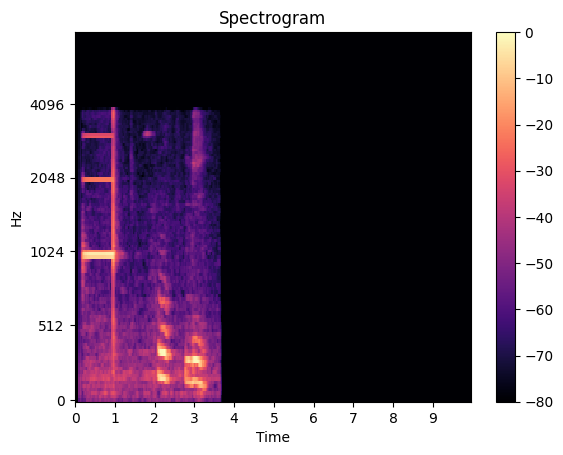

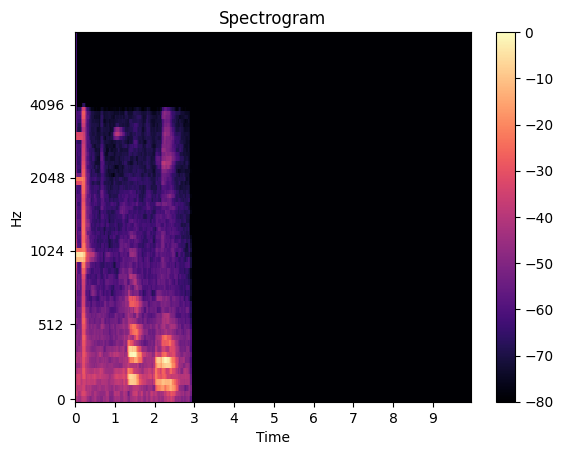

In [ ]:
path = path_list[num]
print(path.split('/')[8])

import librosa.display
plt.figure()
librosa.display.specshow(np.transpose(orig_pre.squeeze()), sr=16000, x_axis='time', y_axis='mel')
plt.colorbar()
plt.title('Spectrogram')
plt.show()

import librosa.display
plt.figure()
librosa.display.specshow(np.transpose(beep_pre.squeeze()), sr=16000, x_axis='time', y_axis='mel')
plt.colorbar()
plt.title('Spectrogram')
plt.show()

In [ ]:
# beep 제거 예측

x_pred_data = pred_preprocess_beep(path, n_mels=80)
ori_tensor, pred_tensor, pred_idx_seq, jamo_pred_seq, final_pred = model_predict(model, x_pred_data)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


In [ ]:
final_pred

'안 다 드 머믄머머므개이'

In [ ]:
ans = {1 : '나비',
       2 : '포도',
       3 : '기타',
       4 : '수갑',
       5 : '가위',
       6 : '모기',
       7 : '칼',
       8 : '꽁치',
       9 : '돼지',
       10 : '택시',
       11 : '호미',
       12 : '비행기',
       13 : '레몬',
       14 : '주사기',
       15 : '짬뽕',
       16 : '빨대',
       17 : '바퀴',
       18 : '쓰레기통',
       19 : '옷걸이',
       20 : '책장',
       21 : '떡국',
       22 : '바구니',
       23 : '열쇠',
       24 : '방패',
       25 : '얼음'
       }

In [ ]:
num=50
for path in path_list[num:num+10]:
  x_pred_data = pred_preprocess_beep(path, n_mels=80)
  ori_tensor, pred_tensor, pred_idx_seq, jamo_pred_seq, final_pred = model_predict(model, x_pred_data)
  print(path)
  print(ans[int(path.split('/')[8].split('_')[2])], final_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
/content/drive/MyDrive/Sesac/한상훈과아이들/image_speech/d_2/3030_p_15_0.wav
짬뽕 나나남딘돈드 뭐 ㄴ므머너 멈 앙망 마 ㅝㅁㄴㅁㄴㅎ 믄 모 믄 무믄 머 ㅡㅁ단암한 믄 만 뭐다믄 마 ㅏ 머뭐 멊그ㅗ
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
/content/drive/MyDrive/Sesac/한상훈과아이들/image_speech/d_2/3030_p_18_0.wav
쓰레기통 아 ㅏㅡ는 느년 머는 그리 티 이너ㅗ 거머잉 헨 이ㅓ론근익자뇨
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
/content/drive/MyDrive/Sesac/한상훈과아이들/image_speech/d_2/3029_p_2_0.wav
포도 잘ㄷ므마으버노
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
/content/drive/MyDrive/Sesac/한상훈과아이들/image_speech/d_2/3029_p_11_0.wav
호미 그마무므래
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
/content/drive/MyDrive/Sesac/한상훈과아이들/image_speech/d_2/3030_p_23_0.wav
열쇠 안 만은 그니 고리릴ㄷ어아
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/

In [ ]:
from IPython.display import Javascript
from google.colab import output
import io
import base64
from scipy.io.wavfile import write
import numpy as np

# 1. 브라우저에서 마이크 녹음하는 JavaScript
JS_CODE = """
async function recordAudio() {
  const stream = await navigator.mediaDevices.getUserMedia({ audio: true });
  const mediaRecorder = new MediaRecorder(stream);
  let chunks = [];

  mediaRecorder.ondataavailable = e => {
    if (e.data.size > 0) {
      chunks.push(e.data);
    }
  };

  mediaRecorder.start();

  await new Promise(resolve => setTimeout(resolve, 5000)); // 5초 녹음
  mediaRecorder.stop();

  await new Promise(resolve => {
    mediaRecorder.onstop = () => {
      const blob = new Blob(chunks, { type: 'audio/wav' });
      const reader = new FileReader();
      reader.onload = () => {
        const base64data = reader.result.split(',')[1];
        google.colab.kernel.invokeFunction('notebook.getAudio', [base64data], {});
        resolve();
      };
      reader.readAsDataURL(blob);
    };
  });
}

recordAudio();
"""

# 2. Python에서 base64로 전달받은 오디오 데이터를 wav로 저장
audio_data = {}

def get_audio(b64):
    global audio_data
    audio_data['wav'] = base64.b64decode(b64)

In [ ]:
output.register_callback('notebook.getAudio', get_audio)

# 3. 녹음 시작
display(Javascript(JS_CODE))

# 4. 데이터 저장
import time
time.sleep(6)  # 녹음 시간(5초) + 여유 1초

if 'wav' in audio_data:
    with open("recorded.wav", "wb") as f:
        f.write(audio_data['wav'])
    print("✅ recorded.wav 저장 완료")
else:
    print("❌ 녹음 데이터가 없습니다.")

<IPython.core.display.Javascript object>

✅ recorded.wav 저장 완료


In [ ]:
# beep 제거 예측

x_pred_data = pred_preprocess("recorded.wav", n_mels=80)
ori_tensor, pred_tensor, pred_idx_seq, jamo_pred_seq, final_pred = model_predict(model, x_pred_data)

/tmp/ipython-input-54735773.py:3: UserWarning: PySoundFile failed. Trying audioread instead.
  ori_y1, sr1 = librosa.load(wav, sr=sr)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


In [ ]:
final_pred

'여녕ㅅ요용ㄹㅁ ㄴ다 아 ㅇㄴ ㄴㅇㄴㅇㄴ하'

In [ ]:
# GRU Attention * 2 GRU
def hardtanh(x, min_val=-20.0, max_val=20.0):
    return tf.clip_by_value(x, min_val, max_val)

def compare(input_shape=(312, 80, 1), num_classes=55, rnn_layer_num = 1, l1=0.0, l2=0.0):
    inputs = tf.keras.Input(shape=input_shape, name="input")

    # 1. Feature Extractor (MaskCNN)
    conv2d_1 = layers.Conv2D(32, kernel_size=(11, 41), strides=(2, 2), padding='same', use_bias=False)
    conv2d_1_out = conv2d_1(inputs)
    BatNor_1 = layers.BatchNormalization(momentum=0.1, epsilon=1e-5)
    BatNor_1_out = BatNor_1(conv2d_1_out)
    hardtanh_1 = layers.Activation(hardtanh)
    hardtanh_1_out = hardtanh_1(BatNor_1_out)

    conv2d_2 = layers.Conv2D(32, kernel_size=(11, 21), strides=(1, 2), padding='same', use_bias=False)
    conv2d_2_out = conv2d_2(hardtanh_1_out)
    BatNor_2 = layers.BatchNormalization(momentum=0.1, epsilon=1e-5)
    BatNor_2_out = BatNor_2(conv2d_2_out)
    hardtanh_2 = layers.Activation(hardtanh)
    hardtanh_2_out = hardtanh_2(BatNor_2_out)

    # 2. Reshape for RNN
    b, t, f, c = hardtanh_2_out.shape  # batch, time, freq, channel
    Reshape_1 = layers.Reshape((-1, f * c))
    x = Reshape_1(hardtanh_2_out)  # merge freq and channel

    # 3. RNN Layers
    for i in range(rnn_layer_num):
        x = layers.BatchNormalization(momentum=0.1, epsilon=1e-5)(x)
        x = layers.Bidirectional(layers.GRU(512,
                                            return_sequences=True,
                                            dropout=0.2,
                                            kernel_regularizer=regularizers.l1_l2(l1=1e-06,l2=1e-04),
                                            recurrent_regularizer=regularizers.l1_l2(l1=1e-06,l2=1e-04)
                                            ),
                                  merge_mode='concat'
                                  )(x)

    # 4. Attention
        att = layers.Attention()
        x = att([x,x])

    x = layers.BatchNormalization(momentum=0.1, epsilon=1e-5)(x)
    x = layers.Bidirectional(layers.GRU(512,
                                        return_sequences=True,
                                        dropout=0.2,
                                        kernel_regularizer=regularizers.l1_l2(l1=1e-06,l2=1e-04),
                                        recurrent_regularizer=regularizers.l1_l2(l1=1e-06,l2=1e-04)
                                        ),
                              merge_mode='concat'
                              )(x)

    # 4. Fully Connected
    LayNor_1 = layers.LayerNormalization()
    LayNor_1_out = LayNor_1(x)
    dense_1 = layers.Dense(num_classes, use_bias=False)
    dense_1_out = dense_1(LayNor_1_out)

    return tf.keras.Model(inputs=inputs, outputs=dense_1_out)

In [ ]:
import itertools

def make_model(l1=0.0, l2=0.0):
    compare_model = compare(l1=l1, l2=l2)
    return compare_model

candidates_l1 = [0.0, 1e-6, 1e-5, 1e-4]
candidates_l2 = [0.0, 1e-6, 1e-5, 1e-4]

results = []
for l1, l2 in tqdm(itertools.product(candidates_l1, candidates_l2)):

    model = make_model(l1, l2)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=CTC(), metrics=['accuracy'])
    hist = model.fit(
        aug_b_x_data[:100], aug_b_y_data[:100],
        validation_data=(aug_b_x_data[100:110], aug_b_y_data[100:110]),
        epochs=50,
        callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)],
        verbose=1, shuffle=False
    )
    best_val = np.min(hist.history['val_loss'])
    results.append((l1, l2, best_val))

# 가장 낮은 val_loss 조합 선택
best = sorted(results, key=lambda x: x[2])[0]
print("Best (l1,l2,val_loss):", best)

0it [00:00, ?it/s]

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 917ms/step - accuracy: 0.0394 - loss: 442.1303 - val_accuracy: 0.1282 - val_loss: 572.3392
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 547ms/step - accuracy: 0.1392 - loss: 451.2791 - val_accuracy: 0.2327 - val_loss: 401.6820
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 556ms/step - accuracy: 0.2024 - loss: 260.1410 - val_accuracy: 0.1712 - val_loss: 213.0125
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 548ms/step - accuracy: 0.2131 - loss: 198.6226 - val_accuracy: 0.1692 - val_loss: 206.7849
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 546ms/step - accuracy: 0.2192 - loss: 184.5836 - val_accuracy: 0.1840 - val_loss: 188.0491
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 548ms/step - accuracy: 0.2262 - loss: 175.5968 - val_accuracy: 0.1878 - val_loss: 182.7816
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 549ms/step - accuracy: 0.2408 - loss: 169.7440 - val_accuracy: 0.2071 - val_loss: 179.2254
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 554ms/step - accuracy: 0.2495 - loss: 163.8680 - va

1it [00:54, 54.14s/it]

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.0821 - loss: 456.5255 - val_accuracy: 0.1596 - val_loss: 608.2721
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 549ms/step - accuracy: 0.2044 - loss: 303.2271 - val_accuracy: 0.1519 - val_loss: 359.3618
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 542ms/step - accuracy: 0.2037 - loss: 281.9375 - val_accuracy: 0.1654 - val_loss: 253.3458
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 543ms/step - accuracy: 0.2043 - loss: 232.8368 - val_accuracy: 0.1718 - val_loss: 227.3300
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 548ms/step - accuracy: 0.2008 - loss: 216.1818 - val_accuracy: 0.1692 - val_loss: 218.3487
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 545ms/step - accuracy: 0.2022 - loss: 202.1233 - val_accuracy: 0.1769 - val_loss: 206.4315
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 549ms/step - accuracy: 0.2067 - loss: 191.5805 - val_accuracy: 0.1737 - val_loss: 199.5688
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 552ms/step - accuracy: 0.2202 - loss: 186.9338 - val_

2it [02:12, 68.25s/it]

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 939ms/step - accuracy: 0.0561 - loss: 429.7457 - val_accuracy: 0.0897 - val_loss: 316.8549
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 555ms/step - accuracy: 0.2009 - loss: 284.0424 - val_accuracy: 0.1641 - val_loss: 295.8702
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 559ms/step - accuracy: 0.2073 - loss: 248.4926 - val_accuracy: 0.1647 - val_loss: 256.6264
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 550ms/step - accuracy: 0.2066 - loss: 223.8298 - val_accuracy: 0.1731 - val_loss: 233.9034
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 542ms/step - accuracy: 0.2107 - loss: 207.2083 - val_accuracy: 0.1712 - val_loss: 221.3603
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 536ms/step - accuracy: 0.2149 - loss: 194.5917 - val_accuracy: 0.1724 - val_loss: 225.5170
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 542ms/step - accuracy: 0.2132 - loss: 188.6769 - val_accuracy: 0.1756 - val_loss: 219.2772
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 544ms/step - accuracy: 0.2176 - loss: 186.5706 - v

3it [03:13, 65.08s/it]

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 932ms/step - accuracy: 0.0645 - loss: 458.4154 - val_accuracy: 0.0506 - val_loss: 378.2717
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 550ms/step - accuracy: 0.2089 - loss: 281.3094 - val_accuracy: 0.1212 - val_loss: 294.6866
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 552ms/step - accuracy: 0.1922 - loss: 233.8786 - val_accuracy: 0.1487 - val_loss: 226.3491
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 550ms/step - accuracy: 0.1980 - loss: 194.9530 - val_accuracy: 0.1532 - val_loss: 209.8276
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 550ms/step - accuracy: 0.2013 - loss: 187.2882 - val_accuracy: 0.1571 - val_loss: 207.5041
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 548ms/step - accuracy: 0.2036 - loss: 186.2355 - val_accuracy: 0.1615 - val_loss: 201.0772
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 550ms/step - accuracy: 0.2039 - loss: 178.7982 - val_accuracy: 0.1577 - val_loss: 194.4388
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 551ms/step - accuracy: 0.2012 - loss: 174.4587 - va

4it [04:25, 67.87s/it]

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 919ms/step - accuracy: 0.0134 - loss: 448.3196 - val_accuracy: 0.0141 - val_loss: 586.5570
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 535ms/step - accuracy: 0.1207 - loss: 472.7962 - val_accuracy: 0.6353 - val_loss: 594.9012
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 548ms/step - accuracy: 0.2004 - loss: 262.0767 - val_accuracy: 0.1673 - val_loss: 269.5923
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 544ms/step - accuracy: 0.2101 - loss: 224.8253 - val_accuracy: 0.1494 - val_loss: 206.7475
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 536ms/step - accuracy: 0.1936 - loss: 198.5704 - val_accuracy: 0.1474 - val_loss: 211.7977
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 542ms/step - accuracy: 0.1908 - loss: 191.2478 - val_accuracy: 0.1558 - val_loss: 198.7666
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 534ms/step - accuracy: 0.1834 - loss: 184.4173 - val_accuracy: 0.1487 - val_loss: 199.4390
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 536ms/step - accuracy: 0.1853 - loss: 180.6542 - va

5it [05:21, 63.57s/it]

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 934ms/step - accuracy: 0.1023 - loss: 461.9619 - val_accuracy: 0.6423 - val_loss: 698.4580
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 544ms/step - accuracy: 0.1865 - loss: 296.8032 - val_accuracy: 0.1571 - val_loss: 308.9358
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 545ms/step - accuracy: 0.2123 - loss: 277.6326 - val_accuracy: 0.1590 - val_loss: 270.3043
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 546ms/step - accuracy: 0.2115 - loss: 228.2308 - val_accuracy: 0.1635 - val_loss: 222.9370
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 547ms/step - accuracy: 0.2057 - loss: 194.3667 - val_accuracy: 0.1769 - val_loss: 202.8050
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 553ms/step - accuracy: 0.2139 - loss: 185.3531 - val_accuracy: 0.1763 - val_loss: 202.0703
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 546ms/step - accuracy: 0.2136 - loss: 181.2513 - val_accuracy: 0.1731 - val_loss: 193.4003
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 536ms/step - accuracy: 0.2109 - loss: 175.7760 - va

6it [06:59, 75.24s/it]

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 936ms/step - accuracy: 0.1268 - loss: 375.0395 - val_accuracy: 0.0776 - val_loss: 342.9353
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 550ms/step - accuracy: 0.4766 - loss: 250.3149 - val_accuracy: 0.4987 - val_loss: 248.4974
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 540ms/step - accuracy: 0.4637 - loss: 202.8045 - val_accuracy: 0.5179 - val_loss: 260.9949
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 550ms/step - accuracy: 0.4861 - loss: 198.4943 - val_accuracy: 0.5115 - val_loss: 206.2690
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 555ms/step - accuracy: 0.4895 - loss: 177.6087 - val_accuracy: 0.5205 - val_loss: 196.3482
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 552ms/step - accuracy: 0.5019 - loss: 169.8419 - val_accuracy: 0.5147 - val_loss: 187.3881
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 550ms/step - accuracy: 0.4995 - loss: 165.1856 - val_accuracy: 0.5192 - val_loss: 187.2988
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 550ms/step - accuracy: 0.5062 - loss: 161.5141 - va

7it [07:51, 67.71s/it]

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 922ms/step - accuracy: 0.0559 - loss: 411.7895 - val_accuracy: 0.2949 - val_loss: 532.1793
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 548ms/step - accuracy: 0.0331 - loss: 364.1090 - val_accuracy: 0.5071 - val_loss: 228.7391
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 541ms/step - accuracy: 0.1106 - loss: 222.1385 - val_accuracy: 0.0885 - val_loss: 230.0562
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 552ms/step - accuracy: 0.0864 - loss: 187.3481 - val_accuracy: 0.0750 - val_loss: 194.7600
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 548ms/step - accuracy: 0.1211 - loss: 174.6883 - val_accuracy: 0.0853 - val_loss: 184.5261
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 552ms/step - accuracy: 0.1609 - loss: 165.1465 - val_accuracy: 0.1391 - val_loss: 180.0071
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 550ms/step - accuracy: 0.2041 - loss: 160.8625 - val_accuracy: 0.1135 - val_loss: 175.9693
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 549ms/step - accuracy: 0.2089 - loss: 158.7159 - va

8it [08:48, 64.12s/it]

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 979ms/step - accuracy: 0.0476 - loss: 454.7986 - val_accuracy: 0.0263 - val_loss: 428.8364
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 546ms/step - accuracy: 0.0246 - loss: 447.9793 - val_accuracy: 0.0173 - val_loss: 458.6199
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 552ms/step - accuracy: 0.0262 - loss: 348.9466 - val_accuracy: 0.0237 - val_loss: 400.7855
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 566ms/step - accuracy: 0.0285 - loss: 287.9888 - val_accuracy: 0.0410 - val_loss: 269.8903
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 568ms/step - accuracy: 0.0389 - loss: 224.2919 - val_accuracy: 0.0455 - val_loss: 237.6751
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 565ms/step - accuracy: 0.0441 - loss: 209.8844 - val_accuracy: 0.0455 - val_loss: 216.9290
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 566ms/step - accuracy: 0.0440 - loss: 189.8495 - val_accuracy: 0.0397 - val_loss: 209.8479
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 566ms/step - accuracy: 0.0482 - loss: 181.5627 - v

9it [10:05, 68.33s/it]

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 949ms/step - accuracy: 0.0724 - loss: 405.7569 - val_accuracy: 0.0417 - val_loss: 348.1202
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 548ms/step - accuracy: 0.2058 - loss: 311.8336 - val_accuracy: 0.1346 - val_loss: 291.5309
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 553ms/step - accuracy: 0.2013 - loss: 265.3210 - val_accuracy: 0.1532 - val_loss: 255.7726
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 549ms/step - accuracy: 0.2000 - loss: 238.9014 - val_accuracy: 0.1609 - val_loss: 230.1234
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 550ms/step - accuracy: 0.2117 - loss: 215.2429 - val_accuracy: 0.1667 - val_loss: 214.0772
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 555ms/step - accuracy: 0.2127 - loss: 200.0927 - val_accuracy: 0.1673 - val_loss: 213.1622
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 551ms/step - accuracy: 0.2248 - loss: 195.7274 - val_accuracy: 0.1821 - val_loss: 202.8983
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 550ms/step - accuracy: 0.2297 - loss: 189.3693 - v

10it [11:09, 66.85s/it]

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 933ms/step - accuracy: 0.0714 - loss: 470.1068 - val_accuracy: 0.6423 - val_loss: 708.2173
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 555ms/step - accuracy: 0.1843 - loss: 370.3405 - val_accuracy: 0.0750 - val_loss: 293.0444
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 551ms/step - accuracy: 0.1959 - loss: 267.2804 - val_accuracy: 0.1340 - val_loss: 243.7237
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 552ms/step - accuracy: 0.1937 - loss: 221.6673 - val_accuracy: 0.1487 - val_loss: 210.3003
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 548ms/step - accuracy: 0.1926 - loss: 194.7134 - val_accuracy: 0.1545 - val_loss: 209.8428
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 551ms/step - accuracy: 0.1909 - loss: 188.2506 - val_accuracy: 0.1596 - val_loss: 198.3972
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 555ms/step - accuracy: 0.1962 - loss: 180.8014 - val_accuracy: 0.1615 - val_loss: 194.7575
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 554ms/step - accuracy: 0.2002 - loss: 176.7573 - v

11it [12:32, 71.85s/it]

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 933ms/step - accuracy: 0.0326 - loss: 437.0134 - val_accuracy: 0.0391 - val_loss: 829.3094
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 549ms/step - accuracy: 0.1574 - loss: 334.7166 - val_accuracy: 0.0833 - val_loss: 352.7259
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 556ms/step - accuracy: 0.1956 - loss: 308.2379 - val_accuracy: 0.1462 - val_loss: 300.6711
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 549ms/step - accuracy: 0.2051 - loss: 258.5111 - val_accuracy: 0.1667 - val_loss: 251.1425
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 550ms/step - accuracy: 0.2118 - loss: 216.7083 - val_accuracy: 0.1731 - val_loss: 224.5815
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 549ms/step - accuracy: 0.2119 - loss: 198.6034 - val_accuracy: 0.1718 - val_loss: 215.6897
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 552ms/step - accuracy: 0.2104 - loss: 191.6977 - val_accuracy: 0.1737 - val_loss: 211.2695
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 556ms/step - accuracy: 0.2121 - loss: 185.2874 - v

12it [14:31, 86.13s/it]

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 930ms/step - accuracy: 0.2188 - loss: 395.5315 - val_accuracy: 0.6147 - val_loss: 586.8181
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 543ms/step - accuracy: 0.4781 - loss: 250.5263 - val_accuracy: 0.5295 - val_loss: 347.4592
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 541ms/step - accuracy: 0.4827 - loss: 217.1962 - val_accuracy: 0.5006 - val_loss: 265.6944
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 548ms/step - accuracy: 0.4751 - loss: 199.6182 - val_accuracy: 0.5064 - val_loss: 243.8495
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 553ms/step - accuracy: 0.4813 - loss: 192.0554 - val_accuracy: 0.5038 - val_loss: 226.0708
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 548ms/step - accuracy: 0.4814 - loss: 185.8038 - val_accuracy: 0.4949 - val_loss: 221.0326
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 552ms/step - accuracy: 0.4836 - loss: 182.6829 - val_accuracy: 0.4955 - val_loss: 219.4729
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 550ms/step - accuracy: 0.4827 - loss: 182.0783 - va

13it [15:45, 82.56s/it]

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 936ms/step - accuracy: 0.0652 - loss: 446.9044 - val_accuracy: 0.0083 - val_loss: 480.3974
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 549ms/step - accuracy: 0.2701 - loss: 296.1310 - val_accuracy: 0.4558 - val_loss: 271.4216
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 551ms/step - accuracy: 0.4809 - loss: 216.1114 - val_accuracy: 0.5115 - val_loss: 257.6047
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 543ms/step - accuracy: 0.4839 - loss: 196.5068 - val_accuracy: 0.5147 - val_loss: 236.6773
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 543ms/step - accuracy: 0.4859 - loss: 191.2269 - val_accuracy: 0.5141 - val_loss: 227.2644
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 545ms/step - accuracy: 0.4875 - loss: 187.1580 - val_accuracy: 0.5141 - val_loss: 224.0758
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 545ms/step - accuracy: 0.4881 - loss: 185.2550 - val_accuracy: 0.5103 - val_loss: 215.9912
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 550ms/step - accuracy: 0.4890 - loss: 181.8027 - v

14it [16:53, 78.09s/it]

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 939ms/step - accuracy: 0.0401 - loss: 458.4786 - val_accuracy: 0.0199 - val_loss: 409.8929
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 541ms/step - accuracy: 0.2092 - loss: 322.3008 - val_accuracy: 0.1327 - val_loss: 345.8112
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 543ms/step - accuracy: 0.2044 - loss: 278.1590 - val_accuracy: 0.1526 - val_loss: 253.9713
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 546ms/step - accuracy: 0.2055 - loss: 235.2867 - val_accuracy: 0.1545 - val_loss: 236.5655
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 549ms/step - accuracy: 0.2021 - loss: 224.5347 - val_accuracy: 0.1603 - val_loss: 233.2865
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 553ms/step - accuracy: 0.2029 - loss: 216.0164 - val_accuracy: 0.1712 - val_loss: 223.1839
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 547ms/step - accuracy: 0.2019 - loss: 213.6077 - val_accuracy: 0.1731 - val_loss: 219.5839
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 545ms/step - accuracy: 0.2066 - loss: 208.0302 - va

15it [18:02, 75.45s/it]

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 929ms/step - accuracy: 0.1504 - loss: 519.0704 - val_accuracy: 0.0237 - val_loss: 884.2004
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 552ms/step - accuracy: 0.1847 - loss: 443.0520 - val_accuracy: 0.1038 - val_loss: 708.4703
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 547ms/step - accuracy: 0.2099 - loss: 268.6293 - val_accuracy: 0.1699 - val_loss: 280.1160
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 549ms/step - accuracy: 0.2095 - loss: 241.4373 - val_accuracy: 0.1705 - val_loss: 256.5817
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 547ms/step - accuracy: 0.2065 - loss: 219.1466 - val_accuracy: 0.1750 - val_loss: 219.4817
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 540ms/step - accuracy: 0.2084 - loss: 201.9989 - val_accuracy: 0.1699 - val_loss: 222.2078
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 553ms/step - accuracy: 0.2179 - loss: 198.0166 - val_accuracy: 0.1692 - val_loss: 216.9887
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 550ms/step - accuracy: 0.2213 - loss: 194.1252 - va

16it [19:10, 71.88s/it]

Best (l1,l2,val_loss): (1e-06, 0.0001, np.float64(170.1720733642578))


In [ ]:
# val_loss 목표치 무한루프

train_model_history = {}
train_model_history_loss = []
train_model_history_val_loss = []
train_model_history_accuracy = []
train_model_history_val_accuracy = []

min_val_loss = 900
cnt = 0
switch = True
cnt_epoch = 1


files = os.listdir(save_path)
files.sort()
files_with_loss = [(f, extract_loss(f)) for f in files]
files_sorted = sorted(files_with_loss, key=lambda x: x[1])
min_loss_file = [f for f, _ in files_sorted[0:1]]
min_val_loss = min_loss_file[0].split('CTC_')[1].split('.k')[0]

model_path = f"{save_path}/{min_loss_file[0]}"
def hardtanh(x, min_val=-20.0, max_val=20.0):
  return tf.clip_by_value(x, min_val, max_val)

model = tf.keras.models.load_model(
  model_path,
  custom_objects={
    "hardtanh": hardtanh,
    'CTC': CTC()
    }
)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=CTC(), metrics=['accuracy'])
print('='*10,f'{save_path}/{min_loss_file[0]}','='*10)

while (float(min_val_loss) > 10) and switch:

  print(f'epoch: {cnt_epoch}',end=' / ')

  files = os.listdir(save_path)
  files.sort()
  files_with_loss = [(f, extract_loss(f)) for f in files]
  files_sorted = sorted(files_with_loss, key=lambda x: x[1])
  min_loss_file = [f for f, _ in files_sorted[0:1]]

  # train_valid set 랜덤 지정
  idx_list = random.sample(range(0, len(x_data)), len(x_data))

  aug_b_x_data = x_data[idx_list[:8000]]
  aug_b_y_data = y_data[idx_list[:8000]]
  valid_x_data = x_data[idx_list[8000:]]
  valid_y_data = y_data[idx_list[8000:]]

  # # 증간된 데이터 추가
  # train_x_data, train_y_data = make_aug_dataset(aug_b_x_data,x_data_length,aug_b_y_data,5000)

  train_model = model.fit(aug_b_x_data,
                          aug_b_y_data,
                          batch_size=64,
                          validation_data=(valid_x_data, valid_y_data),
                          # validation_split=0.1,
                          epochs=1,
                          # callbacks=[EarlyStopping(monitor='val_loss',patience=5),
                          #           ModelCheckpoint(filepath=save_path+'/KoSp_tf_CTC_{val_loss:3.4f}.keras', monitor='val_loss', save_best_only=True, verbose=1)]
                          )

  # 학습 history 저장
  cnt_epoch += 1

  train_model_history_loss.append(train_model.history['loss'][0])
  train_model_history_val_loss.append(train_model.history['val_loss'][0])
  train_model_history_accuracy.append(train_model.history['accuracy'][0])
  train_model_history_val_accuracy.append(train_model.history['val_accuracy'][0])

  train_model_history['loss'] = train_model_history_loss
  train_model_history['val_loss'] = train_model_history_val_loss
  train_model_history['accuracy'] = train_model_history_accuracy
  train_model_history['val_accuracy'] = train_model_history_val_accuracy

  # 학습된 val_loss값이 최소 val_loss보다 작으면 모델 저장
  if train_model.history['val_loss'][0] < float(min_val_loss):
    model.save(f"{save_path}/KoSp_tf_CTC_{train_model.history['val_loss'][0]:3.4f}.keras")
    cnt = 1
    print(f"cnt reset / ***new*** min_val_loss:{train_model.history['val_loss'][0]}")
  # 학습된 val_loss값이 최소 val_loss보다 크면 patient +1
  else:
    if cnt >= 5:
      switch = False
    cnt += 1
    print(f'cnt: {cnt} / min_val_loss: {min_val_loss}')
    continue

  # 저장된 모델이 3개가 넘어가면 가장 val_loss가 높은 모델 제거
  files = os.listdir(save_path)
  files.sort()

  files_with_loss = [(f, extract_loss(f)) for f in files]
  files_sorted = sorted(files_with_loss, key=lambda x: x[1])

  if len(files_sorted) > 3:
    top_k = 3
    files_to_remove = [f for f, _ in files_sorted[top_k:]]

    for filename in files_to_remove:
      file_id = get_file_id_by_name(filename)
      if file_id:
        permanently_delete_file(file_id)

  min_loss_file = [f for f, _ in files_sorted[0:1]]
  min_val_loss = min_loss_file[0].split('CTC_')[1].split('.k')[0]

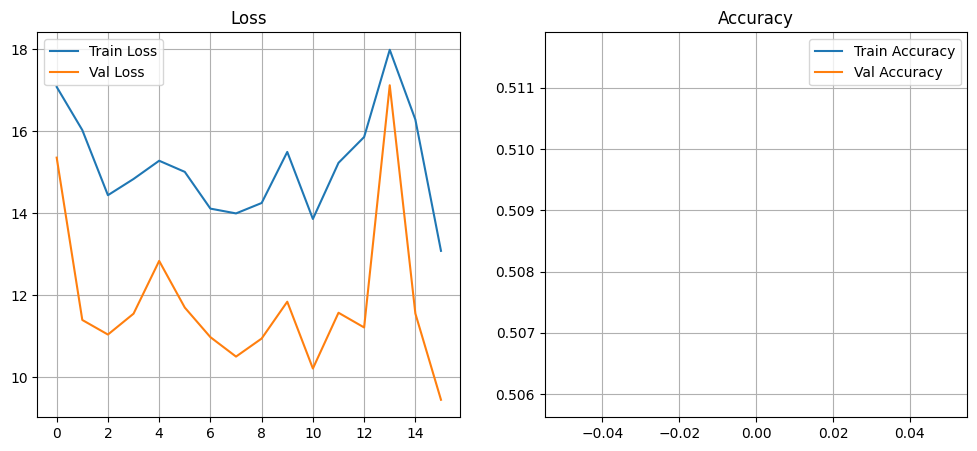

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Loss
ax[0].plot(train_model_history['loss'], label='Train Loss')
ax[0].plot(train_model_history['val_loss'], label='Val Loss')
ax[0].set_title('Loss')
ax[0].legend()
ax[0].grid(True)

# Accuracy
ax[1].plot(train_model.history['accuracy'], label='Train Accuracy')
ax[1].plot(train_model.history['val_accuracy'], label='Val Accuracy')
ax[1].set_title('Accuracy')
ax[1].legend()
ax[1].grid(True)

plt.show()